# 載入 package

In [1]:
%pip install -q -U transformers
%pip install -q -U gdown

In [2]:
import nltk
nltk.download('punkt')
from nltk.tokenize import wordpunct_tokenize

import pandas as pd
import numpy as np
import re
import calendar
from tqdm import tqdm

from sklearn.preprocessing import OrdinalEncoder

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, RandomSampler
from transformers import AutoTokenizer, AutoModel


from sklearn.metrics import cohen_kappa_score, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from matplotlib.pyplot import figure


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


# 載入模型

In [4]:
tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased', add_special_tokens=True)
bert = AutoModel.from_pretrained('/content/drive/distilbert_sess_all')  # 載入經過 finetuning 的模型

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:
class BERTClass(torch.nn.Module):
    def __init__(self, num_labels):
        super(BERTClass, self).__init__()
        self.l1 = bert
        self.layer = nn.Sequential(
            nn.Linear(768, 768),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(768, num_labels),
            )

    def forward(self, ids, mask):
        outputs = self.l1(ids, attention_mask = mask, return_dict = True,  output_hidden_states=True)
        output = self.layer(outputs.last_hidden_state[:,0,:])
        return output

In [8]:
model = BERTClass(14)

In [9]:
model.load_state_dict(torch.load('/content/drive/distilbert_sess_all.pt'))  # 載入經過 finetuning 的模型
model.to(device)

BERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featu

# 載入資料

## 2022/11

In [11]:
df_11_test = pd.read_pickle("/content/ap_table_202211_abnormal_test.pkl")

## 2022/12

In [13]:
df_12_test = pd.read_pickle("/content/ap_table_202212_abnormal_test.pkl")

## 2023/01

In [15]:
df_01_test = pd.read_pickle("/content/ap_table_202301_abnormal_test.pkl")

## 2023/02

In [17]:
df_02_test = pd.read_pickle("/content/ap_table_202302_abnormal_test.pkl")

## 2023/03

In [19]:
df_03_test = pd.read_pickle("/content/ap_table_202303_abnormal_test.pkl")

## 2023/04

In [21]:
df_04_test = pd.read_pickle("/content/ap_table_202304_abnormal_test.pkl")

## 2023/05

In [23]:
df_05_test = pd.read_pickle("/content/ap_table_202305_abnormal_test.pkl")

## 2023/06

In [25]:
df_06_test = pd.read_pickle("/content/ap_table_202306_abnormal_test.pkl")

## 2023/07

In [27]:
df_07_test = pd.read_pickle("/content/ap_table_202307_abnormal_test.pkl")

## 2023/08

In [29]:
df_08_test = pd.read_pickle("/content/ap_table_202308_abnormal_test.pkl")

## 2023/09

In [31]:
df_09_test = pd.read_pickle("/content/ap_table_202309_abnormal_test.pkl")

## 2023/10

In [33]:
df_10_test = pd.read_pickle("/content/ap_table_202310_abnormal_test.pkl")

# Reset Index

In [34]:
df_11_test = df_11_test.reset_index(drop=True).sample(frac=1).reset_index(drop=True)
df_12_test = df_12_test.reset_index(drop=True).sample(frac=1).reset_index(drop=True)
df_01_test = df_01_test.reset_index(drop=True).sample(frac=1).reset_index(drop=True)
df_02_test = df_02_test.reset_index(drop=True).sample(frac=1).reset_index(drop=True)
df_03_test = df_03_test.reset_index(drop=True).sample(frac=1).reset_index(drop=True)
df_04_test = df_04_test.reset_index(drop=True).sample(frac=1).reset_index(drop=True)
df_05_test = df_05_test.reset_index(drop=True).sample(frac=1).reset_index(drop=True)
df_06_test = df_06_test.reset_index(drop=True).sample(frac=1).reset_index(drop=True)
df_07_test = df_07_test.reset_index(drop=True).sample(frac=1).reset_index(drop=True)
df_08_test = df_08_test.reset_index(drop=True).sample(frac=1).reset_index(drop=True)
df_09_test = df_09_test.reset_index(drop=True).sample(frac=1).reset_index(drop=True)
df_10_test = df_10_test.reset_index(drop=True).sample(frac=1).reset_index(drop=True)

# Segmentaion Funtion

In [35]:
def tokenization_addspace_new(s):
  word_list = wordpunct_tokenize(s.replace('[SEP]', 'Æ ')) # [SEP] 用 Æ 取代
  new_string = ""
  for i in range(len(word_list)):
    temp = re.split('([^a-zA-Z0-9])',word_list[i]) # 用特殊字元做文字分割
    for j in range(len(temp)):
      if temp[j] != "":  # 如果不是空字元
        if j != len(temp) - 2 and j != len(temp) - 1: # 如果不是最後兩個字元，則加空格
          if temp[j] == 'Æ':
            new_string += '[SEP]' + " " # 把 Æ 換回成 [SEP]
          else:
            new_string += temp[j] + " "
        else:
          if temp[j] == 'Æ':
            new_string += '[SEP]'
          else:
            new_string += temp[j]
    if i != len(word_list) - 1:
      new_string += " "  # 加空格
  return new_string.lower()  # 全部變小寫

# 文字前處理

In [36]:
df_11_test['text'] = ""
df_11_test['text'] = df_11_test['clean_payload_list'].apply(lambda x: tokenization_addspace_new(x))

df_12_test['text'] = ""
df_12_test['text'] = df_12_test['clean_payload_list'].apply(lambda x: tokenization_addspace_new(x))

df_01_test['text'] = ""
df_01_test['text'] = df_01_test['clean_payload_list'].apply(lambda x: tokenization_addspace_new(x))

df_02_test['text'] = ""
df_02_test['text'] = df_02_test['clean_payload_list'].apply(lambda x: tokenization_addspace_new(x))

df_03_test['text'] = ""
df_03_test['text'] = df_03_test['clean_payload_list'].apply(lambda x: tokenization_addspace_new(x))

df_04_test['text'] = ""
df_04_test['text'] = df_04_test['clean_payload_list'].apply(lambda x: tokenization_addspace_new(x))

df_05_test['text'] = ""
df_05_test['text'] = df_05_test['clean_payload_list'].apply(lambda x: tokenization_addspace_new(x))

df_06_test['text'] = ""
df_06_test['text'] = df_06_test['clean_payload_list'].apply(lambda x: tokenization_addspace_new(x))

df_07_test['text'] = ""
df_07_test['text'] = df_07_test['clean_payload_list'].apply(lambda x: tokenization_addspace_new(x))

df_08_test['text'] = ""
df_08_test['text'] = df_08_test['clean_payload_list'].apply(lambda x: tokenization_addspace_new(x))

df_09_test['text'] = ""
df_09_test['text'] = df_09_test['clean_payload_list'].apply(lambda x: tokenization_addspace_new(x))

df_10_test['text'] = ""
df_10_test['text'] = df_10_test['clean_payload_list'].apply(lambda x: tokenization_addspace_new(x))

In [37]:
df_11_test = df_11_test[df_11_test.text != ""].reset_index(drop=True).sample(frac=1).reset_index(drop=True)
df_12_test = df_12_test[df_12_test.text != ""].reset_index(drop=True).sample(frac=1).reset_index(drop=True)
df_01_test = df_01_test[df_01_test.text != ""].reset_index(drop=True).sample(frac=1).reset_index(drop=True)
df_02_test = df_02_test[df_02_test.text != ""].reset_index(drop=True).sample(frac=1).reset_index(drop=True)
df_03_test = df_03_test[df_03_test.text != ""].reset_index(drop=True).sample(frac=1).reset_index(drop=True)
df_04_test = df_04_test[df_04_test.text != ""].reset_index(drop=True).sample(frac=1).reset_index(drop=True)
df_05_test = df_05_test[df_05_test.text != ""].reset_index(drop=True).sample(frac=1).reset_index(drop=True)
df_06_test = df_06_test[df_06_test.text != ""].reset_index(drop=True).sample(frac=1).reset_index(drop=True)
df_07_test = df_07_test[df_07_test.text != ""].reset_index(drop=True).sample(frac=1).reset_index(drop=True)
df_08_test = df_08_test[df_08_test.text != ""].reset_index(drop=True).sample(frac=1).reset_index(drop=True)
df_09_test = df_09_test[df_09_test.text != ""].reset_index(drop=True).sample(frac=1).reset_index(drop=True)
df_10_test = df_10_test[df_10_test.text != ""].reset_index(drop=True).sample(frac=1).reset_index(drop=True)

# Label encoding

In [38]:
category_list = [["Reconnaissance (TA0043)"], ["Resource Development (TA0042)"], ["Initial Access (TA0001)"], ["Execution (TA0002)"], ["Persistence (TA0003)"],
["Privilege Escalation (TA0004)"], ["Defense Evasion (TA0005)"], ["Credential Access (TA0006)"], ["Discovery (TA0007)"], ["Lateral Movement (TA0008)"],
["Collection (TA0009)"], ["Command and Control (TA0011)"], ["Exfiltration (TA0010)"], ["Impact (TA0040)"]]

In [39]:
encoder = OrdinalEncoder(dtype = int)
encoder.fit(category_list)

OrdinalEncoder(dtype=<class 'int'>)

In [40]:
encoder.categories_

[array(['Collection (TA0009)', 'Command and Control (TA0011)',
        'Credential Access (TA0006)', 'Defense Evasion (TA0005)',
        'Discovery (TA0007)', 'Execution (TA0002)',
        'Exfiltration (TA0010)', 'Impact (TA0040)',
        'Initial Access (TA0001)', 'Lateral Movement (TA0008)',
        'Persistence (TA0003)', 'Privilege Escalation (TA0004)',
        'Reconnaissance (TA0043)', 'Resource Development (TA0042)'],
       dtype=object)]

In [41]:
df_11_class = df_11_test
df_11_class['Tactic_concate_list'] = df_11_class.Tactic_concate.apply(lambda x: [x])
df_11_class['category'] = encoder.transform(df_11_class['Tactic_concate_list'].tolist())
df_11_class.head()

,Session_ID,Src_ISP,Datetime,Protocol,city,country,isp,iso_code,domain,session_time,...,pkt_num,dist,AP_name,new_observed,sess_num,pot,Tactic_concate,text,Tactic_concate_list,category
0,20221107_中嘉寬頻_http_1667777211.217635000,中嘉寬頻,2022-11-07 07:26:51,http,Taoyuan District,Taiwan,HiNet,TW,hinet.net,1.667777e+09,...,1,0.000000e+00,20221107_12_http_11_46,True,1,glastopf,Command and Control (TA0011),http / version 503 service unavailable [sep] c...,[Command and Control (TA0011)],1
1,20221105_中華電信_http_1667640905.197302000,中華電信,2022-11-05 17:35:05,http,None,Belgium,iTecom bvba,BE,itecom.net,1.667641e+09,...,1,2.384186e-07,20221018_00_http_10_17,False,1,amun,Command and Control (TA0011),get / nice % 20ports % 2c / tri % 6eity . txt ...,[Command and Control (TA0011)],1
2,20221107_中嘉寬頻_http_1667792184.919378000,中嘉寬頻,2022-11-07 11:36:24,http,Thu Dau Mot,Vietnam,FPT Telecom Company,VN,None,1.667792e+09,...,1,1.192093e-07,20221107_12_http_11_70,True,1,glastopf,Command and Control (TA0011),>,[Command and Control (TA0011)],1
3,20221125_台灣固網_http_1669326826.793224000,台灣固網,2022-11-25 05:53:46,http,Amsterdam,Netherlands,SpectraIP B.V.,NL,alsycon.net,1.669327e+09,...,1,1.192093e-07,20221125_06_http_02_3,True,1,dionaea,Credential Access (TA0006),get / ? q = ultrasurf http / version [sep] hos...,[Credential Access (TA0006)],2
4,20221107_中嘉寬頻_http_1667791282.132295000,中嘉寬頻,2022-11-07 11:21:22,http,None,Japan,Research Organization of Information and Systems,JP,None,1.667791e+09,...,1,0.000000e+00,20221107_12_http_11_59,True,1,glastopf,Command and Control (TA0011),http / version 503 service unavailable [sep] c...,[Command and Control (TA0011)],1


In [42]:
df_12_class = df_12_test
df_12_class['Tactic_concate_list'] = df_12_class.Tactic_concate.apply(lambda x: [x])
df_12_class['category'] = encoder.transform(df_12_class['Tactic_concate_list'].tolist())
df_12_class.head()

,Session_ID,Src_ISP,Datetime,Protocol,city,country,isp,iso_code,domain,session_time,...,pkt_num,dist,AP_name,new_observed,sess_num,pot,Tactic_concate,text,Tactic_concate_list,category
0,20221217_台灣固網_http_1671246223.909280000,台灣固網,2022-12-17 11:03:43,http,None,Singapore,Huawei Clouds,SG,None,1.671246e+09,...,1,1.804876e-02,20221217_12_http_02_1,True,1,glastopf,Reconnaissance (TA0043),get / perl / comments / perl / components / co...,[Reconnaissance (TA0043)],12
1,20221215_台灣固網_http_1671076798.616485000,台灣固網,2022-12-15 11:59:58,http,Amsterdam,Netherlands,SpectraIP B.V.,NL,alsycon.net,1.671077e+09,...,1,0.000000e+00,20221215_12_http_02_52,True,1,amun,Reconnaissance (TA0043),get / ? q = ultrasurf http / version [sep] hos...,[Reconnaissance (TA0043)],12
2,20221205_中華電信_http_1670190158.233735000,中華電信,2022-12-05 05:42:38,http,Bazhong,China,China Mobile Guangdong,CN,None,1.670190e+09,...,1,0.000000e+00,20220911_22_http_03_2,False,1,amun,Reconnaissance (TA0043),get / phpmyadmin / index . php http / version ...,[Reconnaissance (TA0043)],12
3,20221214_台灣固網_http_1671032490.771200000,台灣固網,2022-12-14 23:41:30,http,San Jose,United States,FranTech Solutions,US,None,1.671032e+09,...,1,1.788139e-07,20221210_14_http_03_4,False,1,glastopf,Credential Access (TA0006),post / boaform / admin / formlogin http / vers...,[Credential Access (TA0006)],2
4,20221215_中嘉寬頻_http_1671097761.867508000,中嘉寬頻,2022-12-15 17:49:21,http,Amsterdam,Netherlands,SpectraIP B.V.,NL,alsycon.net,1.671098e+09,...,1,0.000000e+00,20221210_14_http_09_12,False,1,cowrie,Reconnaissance (TA0043),get / ? q = ultrasurf http / version [sep] hos...,[Reconnaissance (TA0043)],12


In [43]:
df_01_class = df_01_test
df_01_class['Tactic_concate_list'] = df_01_class.Tactic_concate.apply(lambda x: [x])
df_01_class['category'] = encoder.transform(df_01_class['Tactic_concate_list'].tolist())
df_01_class.head()

,Session_ID,Src_ISP,Datetime,Protocol,city,country,isp,iso_code,domain,session_time,...,pkt_num,dist,AP_name,new_observed,sess_num,pot,Tactic_concate,text,Tactic_concate_list,category
0,20230126_台灣固網_http_1674745838.358011000,台灣固網,2023-01-26 23:10:38,http,Kazan’,Russia,Hostglobal.plus Inc,RU,intek-m.com,1.674746e+09,...,1,1.027584e-04,20221002_21_http_01_5,False,1,glastopf,Collection (TA0009),post / console / images / % 252e % 252e % 252f...,[Collection (TA0009)],0
1,20230117_台灣固網_http_1673949063.362310000,台灣固網,2023-01-17 17:51:03,http,Phoenix,United States,FranTech Solutions,US,None,1.673949e+09,...,1,1.788139e-07,20221210_14_http_03_4,False,1,amun,Credential Access (TA0006),post / boaform / admin / formlogin http / vers...,[Credential Access (TA0006)],2
2,20230107_台灣固網_http_1673040699.684672000,台灣固網,2023-01-07 05:31:39,http,None,Singapore,Huawei Clouds,SG,None,1.673041e+09,...,1,7.577837e-03,20230107_06_http_02_4,True,1,glastopf,Execution (TA0002),get / login / www . google . com / amp / s / h...,[Execution (TA0002)],5
3,20230104_台灣固網_http_1672846923.121322000,台灣固網,2023-01-04 23:42:03,http,None,Canada,OVH SAS,CA,None,1.672847e+09,...,1,1.192093e-07,20230104_23_http_02_11,False,1,glastopf,Execution (TA0002),get / login / ovcgi / . r % 7b % 7d _ vti _cnf...,[Execution (TA0002)],5
4,20230115_台灣固網_http_1673775496.821258000,台灣固網,2023-01-15 17:38:16,http,None,United States,Microsoft bingbot,US,msn.com,1.673775e+09,...,1,1.200902e-02,20230115_18_http_02_0,True,1,glastopf,Reconnaissance (TA0043),get / . br / perl / comments / perl / / etc / ...,[Reconnaissance (TA0043)],12


In [44]:
df_02_class = df_02_test
df_02_class['Tactic_concate_list'] = df_02_class.Tactic_concate.apply(lambda x: [x])
df_02_class['category'] = encoder.transform(df_02_class['Tactic_concate_list'].tolist())
df_02_class.head()

,Session_ID,Src_ISP,Datetime,Protocol,city,country,isp,iso_code,domain,session_time,...,pkt_num,dist,AP_name,new_observed,sess_num,pot,Tactic_concate,text,Tactic_concate_list,category
0,20230227_台灣固網_http_1677488796.169594000,台灣固網,2023-02-27 17:06:36,http,London,United Kingdom,Antaro ltd.,RU,None,1.677489e+09,...,1,1.192093e-07,20230227_01_http_02_13,False,1,glastopf,Execution (TA0002),get / login / ovcgi / awstats . pl ? framename...,[Execution (TA0002)],5
1,20230205_台灣固網_http_1675587763.155451000,台灣固網,2023-02-05 17:02:43,http,None,Canada,OVH SAS,CA,None,1.675588e+09,...,1,2.384186e-07,20230128_05_http_02_9,False,1,glastopf,Reconnaissance (TA0043),get / comments / tools / db . php http / versi...,[Reconnaissance (TA0043)],12
2,20230224_台灣固網_http_1677253030.077897000,台灣固網,2023-02-24 23:37:10,http,Kazan’,Russia,Hostglobal.plus Inc,RU,intek-m.com,1.677253e+09,...,1,0.000000e+00,20230220_20_http_05_4,False,1,glastopf,Collection (TA0009),post / console / images / % 252e % 252e % 252f...,[Collection (TA0009)],0
3,20230217_中嘉寬頻_http_1676627209.843681000,中嘉寬頻,2023-02-17 17:46:49,http,None,Canada,OVH SAS,CA,None,1.676627e+09,...,1,5.960464e-08,20230208_15_http_04_16,False,1,glastopf,Reconnaissance (TA0043),get / login / control / shopdisplaycategories ...,[Reconnaissance (TA0043)],12
4,20230216_台灣固網_http_1676559666.156451000,台灣固網,2023-02-16 23:01:06,http,Boydton,United States,Microsoft bingbot,US,msn.com,1.676560e+09,...,1,1.192093e-07,20230216_19_http_02_8,False,1,glastopf,Reconnaissance (TA0043),get / login / h2w / amadmin . pl http / versio...,[Reconnaissance (TA0043)],12


In [45]:
df_03_class = df_03_test
df_03_class['Tactic_concate_list'] = df_03_class.Tactic_concate.apply(lambda x: [x])
df_03_class['category'] = encoder.transform(df_03_class['Tactic_concate_list'].tolist())
df_03_class.head()

,Session_ID,Src_ISP,Datetime,Protocol,city,country,isp,iso_code,domain,session_time,...,pkt_num,dist,AP_name,new_observed,sess_num,pot,Tactic_concate,text,Tactic_concate_list,category
0,20230307_台灣固網_http_1678138293.782044000,台灣固網,2023-03-07 05:31:33,http,London,United Kingdom,Antaro ltd.,RU,None,1.678138e+09,...,1,2.384186e-07,20230307_01_http_02_2,False,1,glastopf,Reconnaissance (TA0043),get / login / rd . am / http : / junchae . com...,[Reconnaissance (TA0043)],12
1,20230305_台灣固網_http_1677965579.873256000,台灣固網,2023-03-05 05:32:59,http,None,Canada,OVH SAS,CA,None,1.677966e+09,...,1,3.576279e-07,20230129_14_http_02_37,False,1,glastopf,Execution (TA0002),get / comments / pls / admin _ / classes / ado...,[Execution (TA0002)],5
2,20230316_中嘉寬頻_http_1678982195.111110000,中嘉寬頻,2023-03-16 23:56:35,http,London,United Kingdom,Antaro ltd.,RU,None,1.678982e+09,...,1,8.583069e-05,20230315_02_http_11_80,False,1,glastopf,Reconnaissance (TA0043),get / comments / lian . lu / message / / ~ nyo...,[Reconnaissance (TA0043)],12
3,20230314_台灣固網_http_1678806662.579121000,台灣固網,2023-03-14 23:11:02,http,None,Canada,OVH SAS,CA,None,1.678807e+09,...,1,2.980232e-07,20230308_17_http_02_150,False,1,glastopf,Execution (TA0002),get / login . action / www . google . com / am...,[Execution (TA0002)],5
4,20230305_台灣固網_http_1678010140.551915000,台灣固網,2023-03-05 17:55:40,http,None,Canada,OVH SAS,CA,None,1.678010e+09,...,1,4.172325e-07,20230225_10_http_02_14,False,1,glastopf,Reconnaissance (TA0043),get / comments / enc / picture . php http / ve...,[Reconnaissance (TA0043)],12


In [46]:
df_04_class = df_04_test
df_04_class['Tactic_concate_list'] = df_04_class.Tactic_concate.apply(lambda x: [x])
df_04_class['category'] = encoder.transform(df_04_class['Tactic_concate_list'].tolist())
df_04_class.head()

,Session_ID,Src_ISP,Datetime,Protocol,city,country,isp,iso_code,domain,session_time,...,pkt_num,dist,AP_name,new_observed,sess_num,pot,Tactic_concate,text,Tactic_concate_list,category
0,20230407_中嘉寬頻_http_1680858868.107926000,中嘉寬頻,2023-04-07 17:14:28,http,New York,United States,Udasha S.A.,HN,None,1.680859e+09,...,1,0.000000e+00,20230407_01_http_11_155,False,1,glastopf,Reconnaissance (TA0043),get / comments / www . in - almelo . com / use...,[Reconnaissance (TA0043)],12
1,20230404_中嘉寬頻_http_1680622670.727746000,中嘉寬頻,2023-04-04 23:37:50,http,Garland,United States,Cogent Communications,US,None,1.680623e+09,...,1,1.192093e-07,20230330_01_http_11_60,False,1,glastopf,Reconnaissance (TA0043),get / comments / google . tl / userprofile / t...,[Reconnaissance (TA0043)],12
2,20230407_中嘉寬頻_http_1680860480.977124000,中嘉寬頻,2023-04-07 17:41:20,http,Lenexa,United States,Host1Plus,CL,network-crm.com,1.680860e+09,...,1,0.000000e+00,20230407_01_http_11_8,False,1,glastopf,Reconnaissance (TA0043),get / comments / tescobank . pro / princessyvg...,[Reconnaissance (TA0043)],12
3,20230427_中華電信_http_1682566740.126091000,中華電信,2023-04-27 11:39:00,http,Shanghai,China,China Mobile Guangdong,CN,None,1.682567e+09,...,1,2.384186e-07,20221002_20_http_03_15,False,1,amun,Command and Control (TA0011),get / nice % 20ports % 2c / tri % 6eity . txt ...,[Command and Control (TA0011)],1
4,20230417_中華電信_http_1681724416.493394000,中華電信,2023-04-17 17:40:16,http,San Francisco,United States,Digital Ocean,US,None,1.681724e+09,...,1,0.000000e+00,20220914_16_http_08_0,False,1,glastopf,Reconnaissance (TA0043),get / actuator / health http / version [sep] h...,[Reconnaissance (TA0043)],12


In [47]:
df_05_class = df_05_test
df_05_class['Tactic_concate_list'] = df_05_class.Tactic_concate.apply(lambda x: [x])
df_05_class['category'] = encoder.transform(df_05_class['Tactic_concate_list'].tolist())
df_05_class.head()

,Session_ID,Src_ISP,Datetime,Protocol,city,country,isp,iso_code,domain,session_time,...,pkt_num,dist,AP_name,new_observed,sess_num,pot,Tactic_concate,text,Tactic_concate_list,category
0,20230526_台灣固網_http_1685114778.929041000,台灣固網,2023-05-26 23:26:18,http,None,France,OVH SAS,FR,ahrefs.com,1.685115e+09,...,1,9.720445e-03,20230527_00_http_02_5,True,1,glastopf,Execution (TA0002),get / comments / gs / ovcgi / test . php http ...,[Execution (TA0002)],5
1,20230516_中華電信_http_1684251782.354229000,中華電信,2023-05-16 23:43:02,http,Kirkland,United States,Wowrack.com,US,None,1.684252e+09,...,1,2.446389e-02,20230517_00_http_10_2,True,1,glastopf,Execution (TA0002),get / login / ovcgi / gs / q7s7pm13neh7 . php ...,[Execution (TA0002)],5
2,20230527_中嘉寬頻_http_1685178667.287727000,中嘉寬頻,2023-05-27 17:11:07,http,Tallinn,Estonia,HostRoyale Technologies Pvt Ltd,IL,None,1.685179e+09,...,1,0.000000e+00,20230525_12_http_11_1,False,1,glastopf,Reconnaissance (TA0043),get / comments / bgms . cit . net / site / zom...,[Reconnaissance (TA0043)],12
3,20230527_中嘉寬頻_http_1685136098.470283000,中嘉寬頻,2023-05-27 05:21:38,http,None,United States,None,US,None,1.685136e+09,...,1,5.960464e-08,20230527_01_http_11_22,False,1,glastopf,Collection (TA0009),get / comments / naradharvoice . com / ? start...,[Collection (TA0009)],0
4,20230515_台灣固網_http_1684099922.352504000,台灣固網,2023-05-15 05:32:02,http,None,Canada,OVH SAS,CA,None,1.684100e+09,...,1,6.044436e-02,20230515_06_http_02_0,True,1,glastopf,Reconnaissance (TA0043),get / comments / login / lib / homepage . php ...,[Reconnaissance (TA0043)],12


In [48]:
df_06_class = df_06_test
df_06_class['Tactic_concate_list'] = df_06_class.Tactic_concate.apply(lambda x: [x])
df_06_class['category'] = encoder.transform(df_06_class['Tactic_concate_list'].tolist())
df_06_class.head()

,Session_ID,Src_ISP,Datetime,Protocol,city,country,isp,iso_code,domain,session_time,...,pkt_num,dist,AP_name,new_observed,sess_num,pot,Tactic_concate,text,Tactic_concate_list,category
0,20230605_中華電信_http_1685956949.026959000,中華電信,2023-06-05 17:22:29,http,Zurich,Switzerland,Private Layer INC,PA,None,1.685957e+09,...,1,3.576279e-07,20230217_22_http_05_4,False,1,amun,Credential Access (TA0006),post / boaform / admin / formlogin http / vers...,[Credential Access (TA0006)],2
1,20230627_中華電信_http_1687814341.818978000,中華電信,2023-06-27 05:19:01,http,None,Hong Kong,BGPNET Global,US,None,1.687814e+09,...,1,1.192093e-07,20230205_13_http_06_0,False,1,amun,Reconnaissance (TA0043),get / phpmyadmin / index . php http / version ...,[Reconnaissance (TA0043)],12
2,20230625_台灣固網_http_1687640784.070496000,台灣固網,2023-06-25 05:06:24,http,None,France,OVH SAS,FR,ahrefs.com,1.687641e+09,...,1,0.000000e+00,20230625_04_http_02_1,False,1,glastopf,Reconnaissance (TA0043),get / comments / search / lib / index3 . php h...,[Reconnaissance (TA0043)],12
3,20230604_中嘉寬頻_http_1685893581.726498000,中嘉寬頻,2023-06-04 23:46:21,http,Usti nad Orlici,Czechia,TTNET s.r.o.,CZ,ttnet.cz,1.685894e+09,...,1,4.768372e-07,20230602_00_http_11_66,False,1,glastopf,Reconnaissance (TA0043),get / comments / 44706648 - 90 - 2019082718223...,[Reconnaissance (TA0043)],12
4,20230617_台灣固網_http_1686949694.957888000,台灣固網,2023-06-17 05:08:14,http,None,Bulgaria,Tamatiya EOOD,BG,4vendeta.com,1.686950e+09,...,1,2.384186e-07,20230612_22_http_03_0,False,1,amun,Credential Access (TA0006),post / boaform / admin / formlogin http / vers...,[Credential Access (TA0006)],2


In [49]:
df_07_class = df_07_test
df_07_class['Tactic_concate_list'] = df_07_class.Tactic_concate.apply(lambda x: [x])
df_07_class['category'] = encoder.transform(df_07_class['Tactic_concate_list'].tolist())
df_07_class.head()

,Session_ID,Src_ISP,Datetime,Protocol,city,country,isp,iso_code,domain,session_time,...,pkt_num,dist,AP_name,new_observed,sess_num,pot,Tactic_concate,text,Tactic_concate_list,category
0,20230714_中嘉寬頻_http_1689347984.143104000,中嘉寬頻,2023-07-14 23:19:44,http,Madrid,Spain,StackPath LLC,GB,None,1.689348e+09,...,1,2.248287e-04,20230616_10_http_11_9,False,1,glastopf,Reconnaissance (TA0043),get / comments / www2s . biglobe . ne . jp / ~...,[Reconnaissance (TA0043)],12
1,20230717_台灣固網_http_1689563231.497119000,台灣固網,2023-07-17 11:07:11,http,Kirkland,United States,Wowrack.com,US,None,1.689563e+09,...,1,1.192093e-07,20230715_11_http_02_25,False,1,glastopf,Execution (TA0002),get / login / inc / ovcgi / login . php http /...,[Execution (TA0002)],5
2,20230717_中嘉寬頻_http_1689544565.677801000,中嘉寬頻,2023-07-17 05:56:05,http,Los Angeles,United States,DediPath,DE,None,1.689545e+09,...,1,1.578927e-04,20230613_01_http_11_31,False,1,glastopf,Reconnaissance (TA0043),get / comments / bgms . cit . net / site / zom...,[Reconnaissance (TA0043)],12
3,20230707_中華電信_http_1688699188.705630000,中華電信,2023-07-07 11:06:28,http,Los Angeles,United States,IT7 Networks,CA,16clouds.com,1.688699e+09,...,1,0.000000e+00,20230707_03_http_06_3,False,1,amun,Initial Access (TA0001),pfdrt = sc & ln = primefaces & pfdrid = umkljp...,[Initial Access (TA0001)],8
4,20230714_中嘉寬頻_http_1689350073.768318000,中嘉寬頻,2023-07-14 23:54:33,http,Madrid,Spain,StackPath LLC,GB,None,1.689350e+09,...,1,3.544092e-04,20230615_01_http_11_19,False,1,glastopf,Reconnaissance (TA0043),get / comments / tescobank . pro / princessyvg...,[Reconnaissance (TA0043)],12


In [50]:
df_08_class = df_08_test
df_08_class['Tactic_concate_list'] = df_08_class.Tactic_concate.apply(lambda x: [x])
df_08_class['category'] = encoder.transform(df_08_class['Tactic_concate_list'].tolist())
df_08_class.head()

,Session_ID,Src_ISP,Datetime,Protocol,city,country,isp,iso_code,domain,session_time,...,pkt_num,dist,AP_name,new_observed,sess_num,pot,Tactic_concate,text,Tactic_concate_list,category
0,20230826_中嘉寬頻_http_1693063076.826879000,中嘉寬頻,2023-08-26 23:17:56,http,Changwon,South Korea,Korea Telecom,KR,None,1.693063e+09,...,1,0.000000e+00,20221002_20_http_08_1,False,1,glastopf,Execution (TA0002),get / shell ? cd + / tmp ; rm + - rf + * ; wge...,[Execution (TA0002)],5
1,20230817_中嘉寬頻_http_1692222366.554074000,中嘉寬頻,2023-08-17 05:46:06,http,None,United States,WholeSale Internet,US,tcoandco.com,1.692222e+09,...,1,1.894832e-04,20230618_01_http_11_28,False,1,glastopf,Reconnaissance (TA0043),get / comments / lian . lu / message / / ~ nyo...,[Reconnaissance (TA0043)],12
2,20230825_中嘉寬頻_http_1692913013.648054000,中嘉寬頻,2023-08-25 05:36:53,http,San José,Costa Rica,RackNation,CR,None,1.692913e+09,...,1,3.109574e-04,20230602_01_http_11_5,False,1,glastopf,Reconnaissance (TA0043),get / comments / www . alice - d - im - wunder...,[Reconnaissance (TA0043)],12
3,20230804_台灣固網_http_1691161461.816965000,台灣固網,2023-08-04 23:04:21,http,Adelaide,Australia,GSL Networks Pty,AU,None,1.691161e+09,...,1,1.192093e-07,20230706_13_http_02_6,False,1,glastopf,Execution (TA0002),get / login / ovcgi / awstats . pl ? framename...,[Execution (TA0002)],5
4,20230817_台灣固網_http_1692220192.076728000,台灣固網,2023-08-17 05:09:52,http,None,France,OVH SAS,FR,ahrefs.com,1.692220e+09,...,1,1.192093e-07,20230817_06_http_02_6,True,1,glastopf,Reconnaissance (TA0043),get / login / log / search / * . php http / ve...,[Reconnaissance (TA0043)],12


In [51]:
df_09_class = df_09_test
df_09_class['Tactic_concate_list'] = df_09_class.Tactic_concate.apply(lambda x: [x])
df_09_class['category'] = encoder.transform(df_09_class['Tactic_concate_list'].tolist())
df_09_class.head()

,Session_ID,Src_ISP,Datetime,Protocol,city,country,isp,iso_code,domain,session_time,...,pkt_num,dist,AP_name,new_observed,sess_num,pot,Tactic_concate,text,Tactic_concate_list,category
0,20230914_台灣固網_http_1694706568.253939000,台灣固網,2023-09-14 23:49:28,http,Boydton,United States,Microsoft bingbot,US,msn.com,1.694707e+09,...,2,0.021163,20230915_00_http_02_0,True,1,glastopf,Reconnaissance (TA0043),get / login _dl / assets / file : / / / etc / ...,[Reconnaissance (TA0043)],12
1,20230914_中嘉寬頻_http_1694705162.701968000,中嘉寬頻,2023-09-14 23:26:02,http,None,United States,"DataShack, LC",US,None,1.694705e+09,...,1,0.000184,20230620_01_http_11_27,False,1,glastopf,Reconnaissance (TA0043),get / comments / kultamuseo . net / user / pro...,[Reconnaissance (TA0043)],12
2,20230915_台灣固網_http_1694725721.785045000,台灣固網,2023-09-15 05:08:41,http,Boydton,United States,Microsoft bingbot,US,msn.com,1.694726e+09,...,10,0.033214,20230915_06_http_02_18,True,1,glastopf,Execution (TA0002),get / comments / servlet / file : / / / etc / ...,[Execution (TA0002)],5
3,20230907_台灣固網_http_1694036331.546955000,台灣固網,2023-09-07 05:38:51,http,Boydton,United States,Microsoft bingbot,US,msn.com,1.694036e+09,...,2,0.031523,20230907_06_http_02_0,True,1,glastopf,Reconnaissance (TA0043),get / loginck / assets / file : / / / etc / ze...,[Reconnaissance (TA0043)],12
4,20230907_台灣固網_http_1694077515.898186000,台灣固網,2023-09-07 17:05:15,http,Boydton,United States,Microsoft bingbot,US,msn.com,1.694078e+09,...,1,0.006798,20230907_18_http_02_4,True,1,glastopf,Credential Access (TA0006),get / comments / servlet / file : / / / etc / ...,[Credential Access (TA0006)],2


In [52]:
df_10_class = df_10_test
df_10_class['Tactic_concate_list'] = df_10_class.Tactic_concate.apply(lambda x: [x])
df_10_class['category'] = encoder.transform(df_10_class['Tactic_concate_list'].tolist())
df_10_class.head()

,Session_ID,Src_ISP,Datetime,Protocol,city,country,isp,iso_code,domain,session_time,...,pkt_num,dist,AP_name,new_observed,sess_num,pot,Tactic_concate,text,Tactic_concate_list,category
0,20231015_台灣固網_http_1697317955.950939000,台灣固網,2023-10-15 05:12:35,http,None,France,OVH SAS,FR,ahrefs.com,1.697318e+09,...,1,0.000000,20230916_05_http_02_4,False,1,glastopf,Execution (TA0002),get / comments / ovcgi / ovcgi / components / ...,[Execution (TA0002)],5
1,20231016_中嘉寬頻_http_1697469720.828958000,中嘉寬頻,2023-10-16 23:22:00,http,Boydton,United States,Microsoft bingbot,US,msn.com,1.697470e+09,...,1,0.016306,20231017_00_http_11_2,True,1,glastopf,Reconnaissance (TA0043),get / php / comments / anunturi - parbrize . r...,[Reconnaissance (TA0043)],12
2,20231017_台灣固網_http_1697493121.193162000,台灣固網,2023-10-17 05:52:01,http,Boydton,United States,Microsoft bingbot,US,msn.com,1.697493e+09,...,1,0.028133,20231017_06_http_02_1,True,1,glastopf,Reconnaissance (TA0043),get / login / assets / file : / / / etc / jee ...,[Reconnaissance (TA0043)],12
3,20231025_中嘉寬頻_http_1698204550.374826000,中嘉寬頻,2023-10-25 11:29:10,http,Kirkland,United States,Wowrack.com,US,None,1.698205e+09,...,1,0.005139,20231025_12_http_11_3,True,1,glastopf,Execution (TA0002),get / comments / % 252e % 252e % 252e % 252e %...,[Execution (TA0002)],5
4,20231027_台灣固網_http_1698398362.001220000,台灣固網,2023-10-27 17:19:22,http,None,Russia,Petersburg Internet Network ltd.,RU,None,1.698398e+09,...,1,0.010100,20231027_18_http_02_6,True,1,glastopf,Credential Access (TA0006),post / index http / version [sep] user - agent...,[Credential Access (TA0006)],2


# 建立 dataset

In [53]:
def make_val_dataset(tokenizer, train):  # 建立 test dataset
  train_tokens = tokenizer.batch_encode_plus(train['text'].to_list(), max_length = 512, padding="max_length", truncation = True, return_token_type_ids=True)

  train_seq = torch.tensor(train_tokens['input_ids'])
  train_mask = torch.tensor(train_tokens['attention_mask'])
  # train_token = torch.tensor(train_tokens['token_type_ids'])
  train_y = torch.tensor(train['category'].to_list())

  train_data = TensorDataset(train_seq, train_mask, train_y)
  train_sampler = RandomSampler(train_data)
  trainloader = DataLoader(train_data,
                          sampler = train_sampler,
                          batch_size = 512, drop_last=False)

  return trainloader

In [54]:
df_11_test = df_11_class[["text", "category"]]

In [55]:
df_12_test = df_12_class[["text", "category"]]
df_01_test = df_01_class[["text", "category"]]
df_02_test = df_02_class[["text", "category"]]
df_03_test = df_03_class[["text", "category"]]
df_04_test = df_04_class[["text", "category"]]
df_05_test = df_05_class[["text", "category"]]
df_06_test = df_06_class[["text", "category"]]
df_07_test = df_07_class[["text", "category"]]
df_08_test = df_08_class[["text", "category"]]
df_09_test = df_09_class[["text", "category"]]
df_10_test = df_10_class[["text", "category"]]

In [56]:
test_11_dataloader = make_val_dataset(tokenizer, df_11_test)

In [57]:
test_12_dataloader = make_val_dataset(tokenizer, df_12_test)
test_01_dataloader = make_val_dataset(tokenizer, df_01_test)
test_02_dataloader = make_val_dataset(tokenizer, df_02_test)
test_03_dataloader = make_val_dataset(tokenizer, df_03_test)
test_04_dataloader = make_val_dataset(tokenizer, df_04_test)
test_05_dataloader = make_val_dataset(tokenizer, df_05_test)
test_06_dataloader = make_val_dataset(tokenizer, df_06_test)
test_07_dataloader = make_val_dataset(tokenizer, df_07_test)
test_08_dataloader = make_val_dataset(tokenizer, df_08_test)
test_09_dataloader = make_val_dataset(tokenizer, df_09_test)
test_10_dataloader = make_val_dataset(tokenizer, df_10_test)

# 結果

## list

In [58]:
list_1 = encoder.categories_[0].tolist()

## 2022/11

In [60]:
model.eval()

pred_list = []
ans_list = []


with torch.no_grad():
  for batch in tqdm(test_11_dataloader):

    batch = [i.to("cuda") for i in batch]
    sent_id, masks, labels = batch
    preds = model(sent_id, masks)
    outputs = preds.detach().cpu().numpy()
    pred_list.append(outputs)
    ans_list.append(labels.detach().cpu().numpy())

pred_list_final =[]

for i in range(len(pred_list)):
  for j in range(len(pred_list[i])):
    temp = np.argmax(pred_list[i][j])
    pred_list_final.append(temp)

a = pred_list_final
b = [e for sl in ans_list for e in sl]

y_true = np.array(b)
y_pred = np.array(a)

print()
print("Accuracy: %0.4f" % (accuracy_score(y_true, y_pred)))
print("Balance Accuracy: %0.4f" % (balanced_accuracy_score(y_true, y_pred)))
print("Precision macro: %0.4f" % (precision_score(y_true, y_pred, average='macro')))
print("Recall macro: %0.4f" % (recall_score(y_true, y_pred, average='macro')))
print("F1 macro: %0.4f" % (f1_score(y_true, y_pred, average='macro')))
print("Cohen's Kappa: %0.4f " % (cohen_kappa_score(y_true, y_pred)))

100%|██████████| 35/35 [00:57<00:00,  1.63s/it]


Accuracy: 0.9650
Balance Accuracy: 0.9479
Precision macro: 0.9453
Recall macro: 0.9479
F1 macro: 0.9410
Cohen's Kappa: 0.9533 


In [61]:
acc_11 = accuracy_score(y_true, y_pred)
bal_acc_11 = balanced_accuracy_score(y_true, y_pred)
f1_11 = f1_score(y_true, y_pred, average='macro')
kappa_11 = cohen_kappa_score(y_true, y_pred)

In [62]:
set_1 = frozenset(frozenset(encoder.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)))
set_2 = frozenset(list(df_11_class.Tactic_concate.unique()))
set_sum = set_1.union(set_2)
intersection = [x for x in list_1 if x in set_sum]
print(classification_report(y_true, y_pred, target_names=intersection, digits=4, zero_division=0))

                               precision    recall  f1-score   support

          Collection (TA0009)     0.9757    0.9460    0.9606      1019
 Command and Control (TA0011)     1.0000    0.9994    0.9997      3530
   Credential Access (TA0006)     0.9770    0.6075    0.7492      1121
           Discovery (TA0007)     0.8571    0.8571    0.8571        14
           Execution (TA0002)     0.9949    0.9869    0.9909       990
        Exfiltration (TA0010)     0.7373    0.9943    0.8467       175
      Initial Access (TA0001)     0.9967    0.9970    0.9968      3956
    Lateral Movement (TA0008)     0.8750    1.0000    0.9333         7
         Persistence (TA0003)     1.0000    1.0000    1.0000       101
Privilege Escalation (TA0004)     1.0000    1.0000    1.0000        23
      Reconnaissance (TA0043)     0.9295    0.9862    0.9570      6588
Resource Development (TA0042)     1.0000    1.0000    1.0000        57

                     accuracy                         0.9650     17581
    

<Figure size 2000x1000 with 0 Axes>

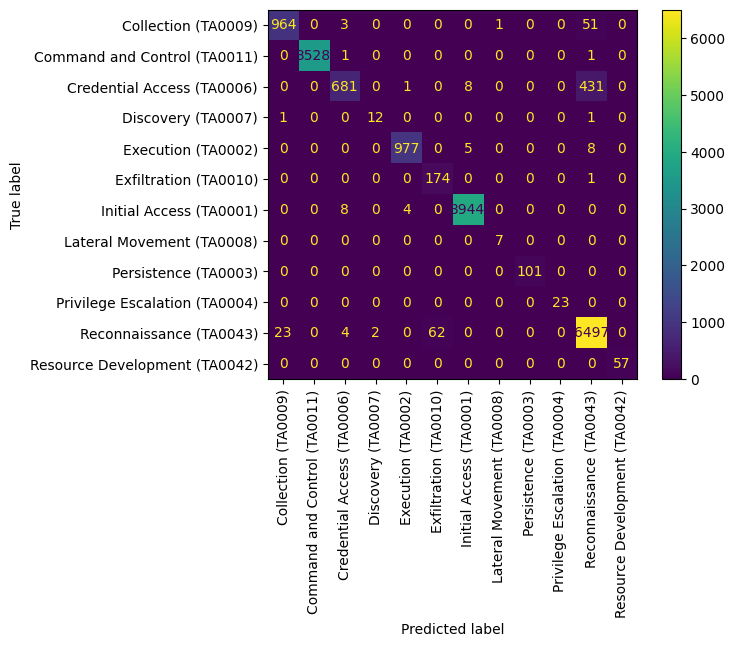

In [63]:
figure(figsize=(20, 10))
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=intersection)
cmd.plot(xticks_rotation='vertical')

## 2022/12

In [64]:
pred_list = []
ans_list = []


with torch.no_grad():
  for batch in tqdm(test_12_dataloader):

    batch = [i.to("cuda") for i in batch]
    sent_id, masks, labels = batch
    preds = model(sent_id, masks)
    outputs = preds.detach().cpu().numpy()
    pred_list.append(outputs)
    ans_list.append(labels.detach().cpu().numpy())

pred_list_final =[]

for i in range(len(pred_list)):
  for j in range(len(pred_list[i])):
    temp = np.argmax(pred_list[i][j])
    pred_list_final.append(temp)

a = pred_list_final
b = [e for sl in ans_list for e in sl]

y_true = np.array(b)
y_pred = np.array(a)

print()
print("Accuracy: %0.4f" % (accuracy_score(y_true, y_pred)))
print("Balance Accuracy: %0.4f" % (balanced_accuracy_score(y_true, y_pred)))
print("Precision macro: %0.4f" % (precision_score(y_true, y_pred, average='macro')))
print("Recall macro: %0.4f" % (recall_score(y_true, y_pred, average='macro')))
print("F1 macro: %0.4f" % (f1_score(y_true, y_pred, average='macro')))
print("Cohen's Kappa: %0.4f " % (cohen_kappa_score(y_true, y_pred)))

100%|██████████| 31/31 [00:50<00:00,  1.64s/it]


Accuracy: 0.8630
Balance Accuracy: 0.7360
Precision macro: 0.8126
Recall macro: 0.7360
F1 macro: 0.7420
Cohen's Kappa: 0.8019 


In [65]:
acc_12 = accuracy_score(y_true, y_pred)
bal_acc_12 = balanced_accuracy_score(y_true, y_pred)
f1_12 = f1_score(y_true, y_pred, average='macro')
kappa_12 = cohen_kappa_score(y_true, y_pred)

In [66]:
set_1 = frozenset(frozenset(encoder.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)))
set_2 = frozenset(list(df_12_class.Tactic_concate.unique()))
set_sum = set_1.union(set_2)
intersection = [x for x in list_1 if x in set_sum]
print(classification_report(y_true, y_pred, target_names=intersection, digits=4, zero_division=0))

                               precision    recall  f1-score   support

          Collection (TA0009)     0.9770    0.8263    0.8954       668
 Command and Control (TA0011)     0.9608    0.8362    0.8942       586
   Credential Access (TA0006)     0.9800    0.7233    0.8323      2302
           Discovery (TA0007)     0.3750    0.5000    0.4286         6
           Execution (TA0002)     0.8360    0.9617    0.8945      4390
        Exfiltration (TA0010)     1.0000    0.9725    0.9860       109
      Initial Access (TA0001)     0.2880    0.8945    0.4357       199
    Lateral Movement (TA0008)     1.0000    0.5000    0.6667        10
         Persistence (TA0003)     0.9940    0.5986    0.7472       279
Privilege Escalation (TA0004)     0.6429    0.4186    0.5070        43
      Reconnaissance (TA0043)     0.8850    0.8642    0.8745      7034

                     accuracy                         0.8630     15626
                    macro avg     0.8126    0.7360    0.7420     15626
    

<Figure size 2000x1000 with 0 Axes>

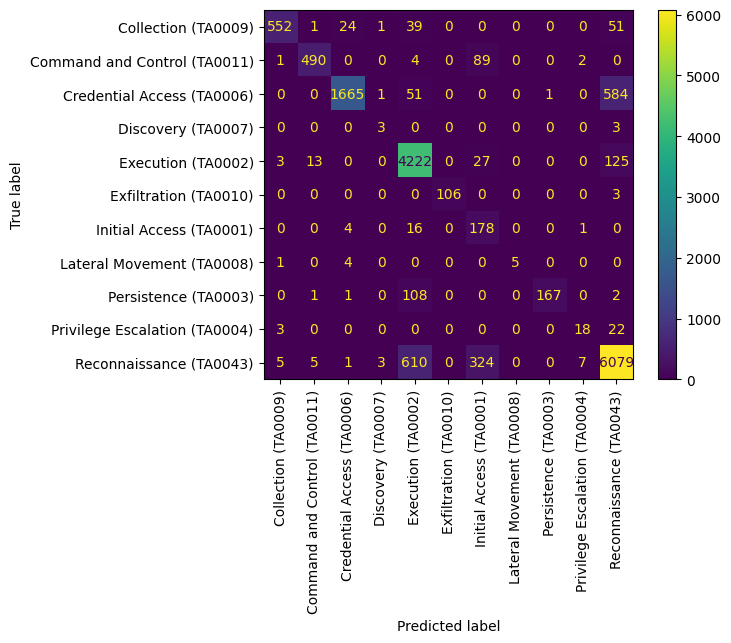

In [67]:
figure(figsize=(20, 10))
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=intersection)
cmd.plot(xticks_rotation='vertical')

## 2023/01

In [68]:
pred_list = []
ans_list = []


with torch.no_grad():
  for batch in tqdm(test_01_dataloader):

    batch = [i.to("cuda") for i in batch]
    sent_id, masks, labels = batch
    preds = model(sent_id, masks)
    outputs = preds.detach().cpu().numpy()
    pred_list.append(outputs)
    ans_list.append(labels.detach().cpu().numpy())

pred_list_final =[]

for i in range(len(pred_list)):
  for j in range(len(pred_list[i])):
    temp = np.argmax(pred_list[i][j])
    pred_list_final.append(temp)

a = pred_list_final
b = [e for sl in ans_list for e in sl]

y_true = np.array(b)
y_pred = np.array(a)

print()
print("Accuracy: %0.4f" % (accuracy_score(y_true, y_pred)))
print("Balance Accuracy: %0.4f" % (balanced_accuracy_score(y_true, y_pred)))
print("Precision macro: %0.4f" % (precision_score(y_true, y_pred, average='macro')))
print("Recall macro: %0.4f" % (recall_score(y_true, y_pred, average='macro')))
print("F1 macro: %0.4f" % (f1_score(y_true, y_pred, average='macro')))
print("Cohen's Kappa: %0.4f " % (cohen_kappa_score(y_true, y_pred)))

100%|██████████| 31/31 [00:51<00:00,  1.65s/it]


Accuracy: 0.9214
Balance Accuracy: 0.7930
Precision macro: 0.8518
Recall macro: 0.7930
F1 macro: 0.7922
Cohen's Kappa: 0.8891 


In [69]:
acc_01 = accuracy_score(y_true, y_pred)
bal_acc_01 = balanced_accuracy_score(y_true, y_pred)
f1_01 = f1_score(y_true, y_pred, average='macro')
kappa_01 = cohen_kappa_score(y_true, y_pred)

In [70]:
set_1 = frozenset(frozenset(encoder.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)))
set_2 = frozenset(list(df_01_class.Tactic_concate.unique()))
set_sum = set_1.union(set_2)
intersection = [x for x in list_1 if x in set_sum]
print(classification_report(y_true, y_pred, target_names=intersection, digits=4, zero_division=0))

                               precision    recall  f1-score   support

          Collection (TA0009)     0.8268    0.8408    0.8337       829
 Command and Control (TA0011)     0.9820    0.8466    0.9093       580
   Credential Access (TA0006)     0.9914    0.9302    0.9599      2609
           Discovery (TA0007)     0.7500    0.3529    0.4800        17
           Execution (TA0002)     0.9094    0.9785    0.9427      4844
        Exfiltration (TA0010)     0.9868    0.9868    0.9868        76
      Initial Access (TA0001)     0.3440    0.9655    0.5072       145
    Lateral Movement (TA0008)     1.0000    1.0000    1.0000         1
         Persistence (TA0003)     1.0000    0.5000    0.6667       180
Privilege Escalation (TA0004)     0.6296    0.4146    0.5000        41
      Reconnaissance (TA0043)     0.9495    0.9065    0.9275      6409

                     accuracy                         0.9214     15731
                    macro avg     0.8518    0.7930    0.7922     15731
    

<Figure size 2000x1000 with 0 Axes>

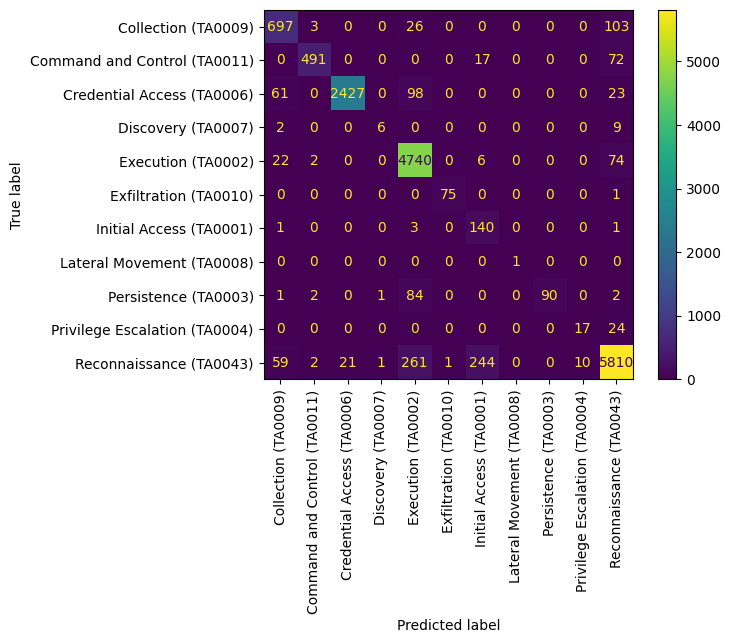

In [71]:
figure(figsize=(20, 10))
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=intersection)
cmd.plot(xticks_rotation='vertical')

## 2023/02

In [72]:
pred_list = []
ans_list = []


with torch.no_grad():
  for batch in tqdm(test_02_dataloader):

    batch = [i.to("cuda") for i in batch]
    sent_id, masks, labels = batch
    preds = model(sent_id, masks)
    outputs = preds.detach().cpu().numpy()
    pred_list.append(outputs)
    ans_list.append(labels.detach().cpu().numpy())

pred_list_final =[]

for i in range(len(pred_list)):
  for j in range(len(pred_list[i])):
    temp = np.argmax(pred_list[i][j])
    pred_list_final.append(temp)

a = pred_list_final
b = [e for sl in ans_list for e in sl]

y_true = np.array(b)
y_pred = np.array(a)

print()
print("Accuracy: %0.4f" % (accuracy_score(y_true, y_pred)))
print("Balance Accuracy: %0.4f" % (balanced_accuracy_score(y_true, y_pred)))
print("Precision macro: %0.4f" % (precision_score(y_true, y_pred, average='macro')))
print("Recall macro: %0.4f" % (recall_score(y_true, y_pred, average='macro')))
print("F1 macro: %0.4f" % (f1_score(y_true, y_pred, average='macro')))
print("Cohen's Kappa: %0.4f " % (cohen_kappa_score(y_true, y_pred)))

100%|██████████| 52/52 [01:25<00:00,  1.64s/it]


Accuracy: 0.9317
Balance Accuracy: 0.7893
Precision macro: 0.8192
Recall macro: 0.7893
F1 macro: 0.7999
Cohen's Kappa: 0.8620 



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
acc_02 = accuracy_score(y_true, y_pred)
bal_acc_02 = balanced_accuracy_score(y_true, y_pred)
f1_02 = f1_score(y_true, y_pred, average='macro')
kappa_02 = cohen_kappa_score(y_true, y_pred)

In [74]:
set_1 = frozenset(frozenset(encoder.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)))
set_2 = frozenset(list(df_02_class.Tactic_concate.unique()))
set_sum = set_1.union(set_2)
intersection = [x for x in list_1 if x in set_sum]
print(classification_report(y_true, y_pred, target_names=intersection, digits=4, zero_division=0))

                               precision    recall  f1-score   support

          Collection (TA0009)     0.8512    0.7471    0.7957      2289
 Command and Control (TA0011)     0.9331    0.8093    0.8668       603
   Credential Access (TA0006)     0.8834    0.8627    0.8729      1748
     Defense Evasion (TA0005)     0.0000    0.0000    0.0000        78
           Discovery (TA0007)     0.5882    0.3125    0.4082        32
           Execution (TA0002)     0.9049    0.9225    0.9136      2012
        Exfiltration (TA0010)     0.9381    0.9579    0.9479        95
      Initial Access (TA0001)     0.8589    0.9464    0.9005      1100
    Lateral Movement (TA0008)     1.0000    1.0000    1.0000         7
         Persistence (TA0003)     0.9200    0.9426    0.9312       122
Privilege Escalation (TA0004)     1.0000    1.0000    1.0000        37
      Reconnaissance (TA0043)     0.9529    0.9706    0.9617     18122

                     accuracy                         0.9317     26245
    

<Figure size 2000x1000 with 0 Axes>

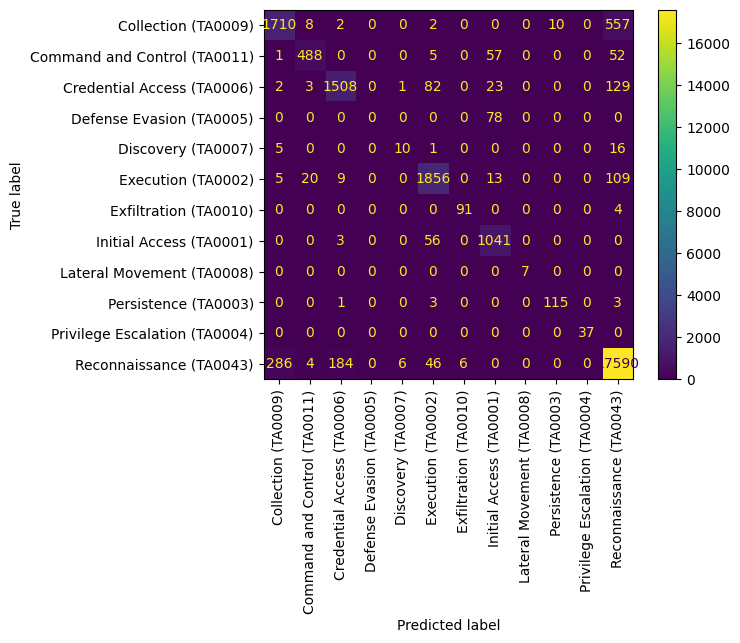

In [75]:
figure(figsize=(20, 10))
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=intersection)
cmd.plot(xticks_rotation='vertical')

## 2023/03

In [76]:
pred_list = []
ans_list = []


with torch.no_grad():
  for batch in tqdm(test_03_dataloader):

    batch = [i.to("cuda") for i in batch]
    sent_id, masks, labels = batch
    preds = model(sent_id, masks)
    outputs = preds.detach().cpu().numpy()
    pred_list.append(outputs)
    ans_list.append(labels.detach().cpu().numpy())

pred_list_final =[]

for i in range(len(pred_list)):
  for j in range(len(pred_list[i])):
    temp = np.argmax(pred_list[i][j])
    pred_list_final.append(temp)

a = pred_list_final
b = [e for sl in ans_list for e in sl]

y_true = np.array(b)
y_pred = np.array(a)

print()
print("Accuracy: %0.4f" % (accuracy_score(y_true, y_pred)))
print("Balance Accuracy: %0.4f" % (balanced_accuracy_score(y_true, y_pred)))
print("Precision macro: %0.4f" % (precision_score(y_true, y_pred, average='macro')))
print("Recall macro: %0.4f" % (recall_score(y_true, y_pred, average='macro')))
print("F1 macro: %0.4f" % (f1_score(y_true, y_pred, average='macro')))
print("Cohen's Kappa: %0.4f " % (cohen_kappa_score(y_true, y_pred)))

100%|██████████| 67/67 [01:51<00:00,  1.66s/it]


Accuracy: 0.9275
Balance Accuracy: 0.7248
Precision macro: 0.8584
Recall macro: 0.7248
F1 macro: 0.7630
Cohen's Kappa: 0.7873 


In [77]:
acc_03 = accuracy_score(y_true, y_pred)
bal_acc_03 = balanced_accuracy_score(y_true, y_pred)
f1_03 = f1_score(y_true, y_pred, average='macro')
kappa_03 = cohen_kappa_score(y_true, y_pred)

In [78]:
set_1 = frozenset(frozenset(encoder.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)))
set_2 = frozenset(list(df_03_class.Tactic_concate.unique()))
set_sum = set_1.union(set_2)
intersection = [x for x in list_1 if x in set_sum]
print(classification_report(y_true, y_pred, target_names=intersection, digits=4, zero_division=0))

                               precision    recall  f1-score   support

          Collection (TA0009)     0.5988    0.4243    0.4967      1678
 Command and Control (TA0011)     0.9767    0.7036    0.8180       776
   Credential Access (TA0006)     0.9616    0.8811    0.9196      1505
           Discovery (TA0007)     0.6389    0.4510    0.5287        51
           Execution (TA0002)     0.9035    0.8566    0.8794      2567
        Exfiltration (TA0010)     0.8333    0.7927    0.8125        82
      Initial Access (TA0001)     0.5831    0.8291    0.6847       275
    Lateral Movement (TA0008)     1.0000    1.0000    1.0000         2
         Persistence (TA0003)     1.0000    0.8065    0.8929        31
Privilege Escalation (TA0004)     1.0000    0.2480    0.3974       125
      Reconnaissance (TA0043)     0.9462    0.9801    0.9629     27007

                     accuracy                         0.9275     34099
                    macro avg     0.8584    0.7248    0.7630     34099
    

<Figure size 2000x1000 with 0 Axes>

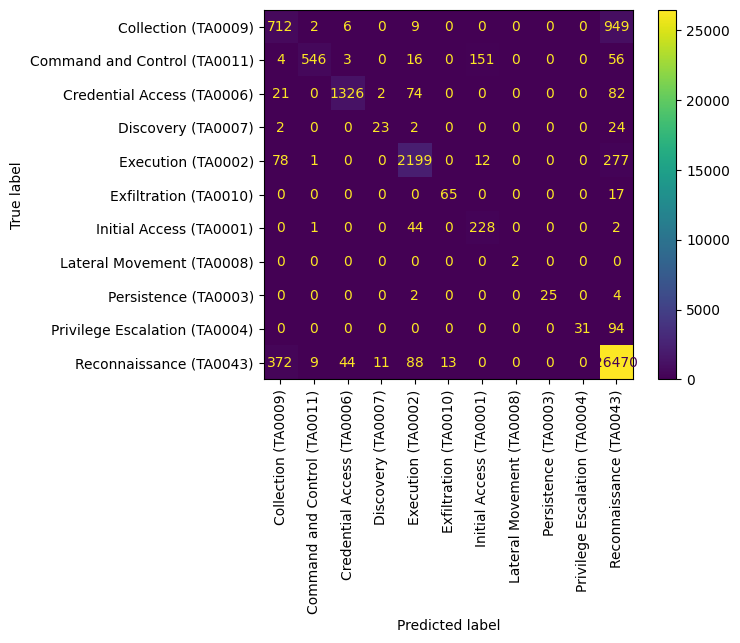

In [79]:
figure(figsize=(20, 10))
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=intersection)
cmd.plot(xticks_rotation='vertical')

## 2023/04

In [80]:
pred_list = []
ans_list = []


with torch.no_grad():
  for batch in tqdm(test_04_dataloader):

    batch = [i.to("cuda") for i in batch]
    sent_id, masks, labels = batch
    preds = model(sent_id, masks)
    outputs = preds.detach().cpu().numpy()
    pred_list.append(outputs)
    ans_list.append(labels.detach().cpu().numpy())

pred_list_final =[]

for i in range(len(pred_list)):
  for j in range(len(pred_list[i])):
    temp = np.argmax(pred_list[i][j])
    pred_list_final.append(temp)

a = pred_list_final
b = [e for sl in ans_list for e in sl]

y_true = np.array(b)
y_pred = np.array(a)

print()
print("Accuracy: %0.4f" % (accuracy_score(y_true, y_pred)))
print("Balance Accuracy: %0.4f" % (balanced_accuracy_score(y_true, y_pred)))
print("Precision macro: %0.4f" % (precision_score(y_true, y_pred, average='macro')))
print("Recall macro: %0.4f" % (recall_score(y_true, y_pred, average='macro')))
print("F1 macro: %0.4f" % (f1_score(y_true, y_pred, average='macro')))
print("Cohen's Kappa: %0.4f " % (cohen_kappa_score(y_true, y_pred)))

100%|██████████| 78/78 [02:09<00:00,  1.66s/it]


Accuracy: 0.8520
Balance Accuracy: 0.5701
Precision macro: 0.7267
Recall macro: 0.5701
F1 macro: 0.6281
Cohen's Kappa: 0.6068 



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [81]:
acc_04 = accuracy_score(y_true, y_pred)
bal_acc_04 = balanced_accuracy_score(y_true, y_pred)
f1_04 = f1_score(y_true, y_pred, average='macro')
kappa_04 = cohen_kappa_score(y_true, y_pred)

In [82]:
set_1 = frozenset(frozenset(encoder.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)))
set_2 = frozenset(list(df_04_class.Tactic_concate.unique()))
set_sum = set_1.union(set_2)
intersection = [x for x in list_1 if x in set_sum]
print(classification_report(y_true, y_pred, target_names=intersection, digits=4, zero_division=0))

                               precision    recall  f1-score   support

          Collection (TA0009)     0.3095    0.2329    0.2658      2568
 Command and Control (TA0011)     0.9418    0.8198    0.8766       888
   Credential Access (TA0006)     0.9507    0.6719    0.7873      1350
     Defense Evasion (TA0005)     0.0000    0.0000    0.0000        23
           Discovery (TA0007)     0.4615    0.1622    0.2400        37
           Execution (TA0002)     0.8340    0.4609    0.5937      4578
        Exfiltration (TA0010)     0.8631    0.9674    0.9123       215
      Initial Access (TA0001)     0.7702    0.6555    0.7082       537
    Lateral Movement (TA0008)     1.0000    0.7143    0.8333        14
         Persistence (TA0003)     0.9000    0.6000    0.7200        15
Privilege Escalation (TA0004)     0.8077    0.5753    0.6720        73
      Reconnaissance (TA0043)     0.8816    0.9808    0.9285     29552

                     accuracy                         0.8520     39850
    

<Figure size 2000x1000 with 0 Axes>

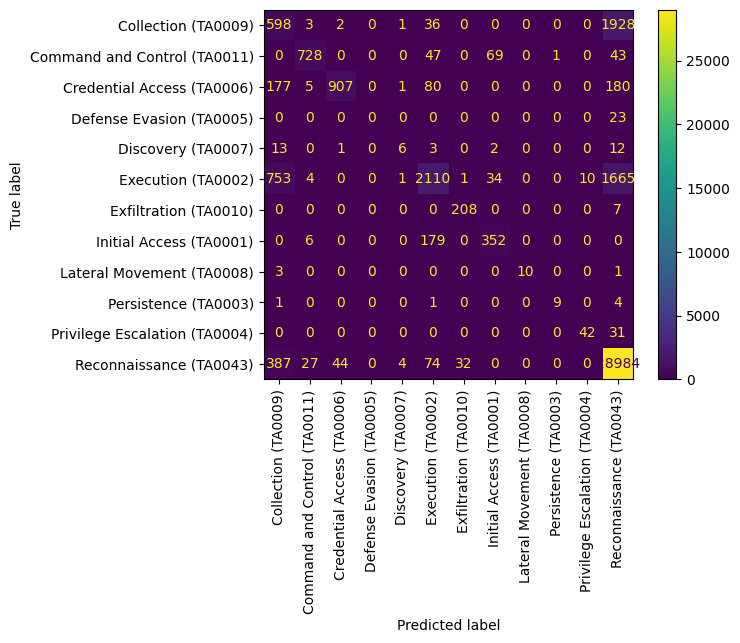

In [83]:
figure(figsize=(20, 10))
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=intersection)
cmd.plot(xticks_rotation='vertical')

## 2023/05

In [84]:
pred_list = []
ans_list = []


with torch.no_grad():
  for batch in tqdm(test_05_dataloader):

    batch = [i.to("cuda") for i in batch]
    sent_id, masks, labels = batch
    preds = model(sent_id, masks)
    outputs = preds.detach().cpu().numpy()
    pred_list.append(outputs)
    ans_list.append(labels.detach().cpu().numpy())

pred_list_final =[]

for i in range(len(pred_list)):
  for j in range(len(pred_list[i])):
    temp = np.argmax(pred_list[i][j])
    pred_list_final.append(temp)

a = pred_list_final
b = [e for sl in ans_list for e in sl]

y_true = np.array(b)
y_pred = np.array(a)

print()
print("Accuracy: %0.4f" % (accuracy_score(y_true, y_pred)))
print("Balance Accuracy: %0.4f" % (balanced_accuracy_score(y_true, y_pred)))
print("Precision macro: %0.4f" % (precision_score(y_true, y_pred, average='macro')))
print("Recall macro: %0.4f" % (recall_score(y_true, y_pred, average='macro')))
print("F1 macro: %0.4f" % (f1_score(y_true, y_pred, average='macro')))
print("Cohen's Kappa: %0.4f " % (cohen_kappa_score(y_true, y_pred)))

100%|██████████| 129/129 [03:33<00:00,  1.66s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Accuracy: 0.8862
Balance Accuracy: 0.6068
Precision macro: 0.6353
Recall macro: 0.6068
F1 macro: 0.5715
Cohen's Kappa: 0.7513 


In [85]:
acc_05 = accuracy_score(y_true, y_pred)
bal_acc_05 = balanced_accuracy_score(y_true, y_pred)
f1_05 = f1_score(y_true, y_pred, average='macro')
kappa_05 = cohen_kappa_score(y_true, y_pred)

In [86]:
set_1 = frozenset(frozenset(encoder.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)))
set_2 = frozenset(list(df_05_class.Tactic_concate.unique()))
set_sum = set_1.union(set_2)
intersection = [x for x in list_1 if x in set_sum]
print(classification_report(y_true, y_pred, target_names=intersection, digits=4, zero_division=0))

                               precision    recall  f1-score   support

          Collection (TA0009)     0.4805    0.4683    0.4743      2315
 Command and Control (TA0011)     0.8846    0.8948    0.8896      1473
   Credential Access (TA0006)     0.6544    0.8426    0.7367      3456
     Defense Evasion (TA0005)     0.0000    0.0000    0.0000         4
           Discovery (TA0007)     0.4634    0.1743    0.2533       109
           Execution (TA0002)     0.8714    0.9375    0.9033      8445
        Exfiltration (TA0010)     0.8714    0.9155    0.8929       296
      Initial Access (TA0001)     0.3262    0.9041    0.4794       657
    Lateral Movement (TA0008)     1.0000    0.2500    0.4000         4
         Persistence (TA0003)     1.0000    0.5596    0.7176       193
Privilege Escalation (TA0004)     0.1151    0.4324    0.1818        37
      Reconnaissance (TA0043)     0.9562    0.9029    0.9288     48661

                     accuracy                         0.8862     65650
    

<Figure size 2000x1000 with 0 Axes>

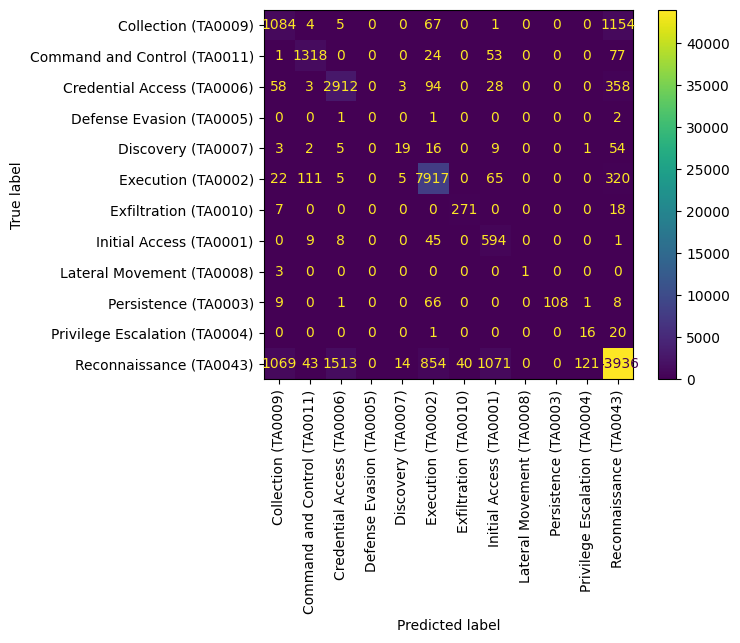

In [87]:
figure(figsize=(20, 10))
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=intersection)
cmd.plot(xticks_rotation='vertical')

## 2023/06

In [88]:
pred_list = []
ans_list = []


with torch.no_grad():
  for batch in tqdm(test_06_dataloader):

    batch = [i.to("cuda") for i in batch]
    sent_id, masks, labels = batch
    preds = model(sent_id, masks)
    outputs = preds.detach().cpu().numpy()
    pred_list.append(outputs)
    ans_list.append(labels.detach().cpu().numpy())

pred_list_final =[]

for i in range(len(pred_list)):
  for j in range(len(pred_list[i])):
    temp = np.argmax(pred_list[i][j])
    pred_list_final.append(temp)

a = pred_list_final
b = [e for sl in ans_list for e in sl]

y_true = np.array(b)
y_pred = np.array(a)

print()
print("Accuracy: %0.4f" % (accuracy_score(y_true, y_pred)))
print("Balance Accuracy: %0.4f" % (balanced_accuracy_score(y_true, y_pred)))
print("Precision macro: %0.4f" % (precision_score(y_true, y_pred, average='macro')))
print("Recall macro: %0.4f" % (recall_score(y_true, y_pred, average='macro')))
print("F1 macro: %0.4f" % (f1_score(y_true, y_pred, average='macro')))
print("Cohen's Kappa: %0.4f " % (cohen_kappa_score(y_true, y_pred)))

100%|██████████| 75/75 [02:03<00:00,  1.65s/it]


Accuracy: 0.9073
Balance Accuracy: 0.6967
Precision macro: 0.7772
Recall macro: 0.6967
F1 macro: 0.7215
Cohen's Kappa: 0.7912 



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:
acc_06 = accuracy_score(y_true, y_pred)
bal_acc_06 = balanced_accuracy_score(y_true, y_pred)
f1_06 = f1_score(y_true, y_pred, average='macro')
kappa_06 = cohen_kappa_score(y_true, y_pred)

In [90]:
set_1 = frozenset(frozenset(encoder.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)))
set_2 = frozenset(list(df_06_class.Tactic_concate.unique()))
set_sum = set_1.union(set_2)
intersection = [x for x in list_1 if x in set_sum]
print(classification_report(y_true, y_pred, target_names=intersection, digits=4, zero_division=0))

                               precision    recall  f1-score   support

          Collection (TA0009)     0.6066    0.5298    0.5656      2401
 Command and Control (TA0011)     0.9487    0.9050    0.9263      1084
   Credential Access (TA0006)     0.9264    0.8189    0.8693      1568
     Defense Evasion (TA0005)     0.0000    0.0000    0.0000         3
           Discovery (TA0007)     0.6471    0.6111    0.6286        18
           Execution (TA0002)     0.9056    0.8585    0.8814      4282
        Exfiltration (TA0010)     0.9942    0.9827    0.9884       173
      Initial Access (TA0001)     0.6073    0.8431    0.7061       510
    Lateral Movement (TA0008)     1.0000    1.0000    1.0000         1
         Persistence (TA0003)     0.8780    0.4390    0.5854       164
Privilege Escalation (TA0004)     0.8774    0.4096    0.5585       332
      Reconnaissance (TA0043)     0.9348    0.9629    0.9486     27473

                     accuracy                         0.9073     38009
    

<Figure size 2000x1000 with 0 Axes>

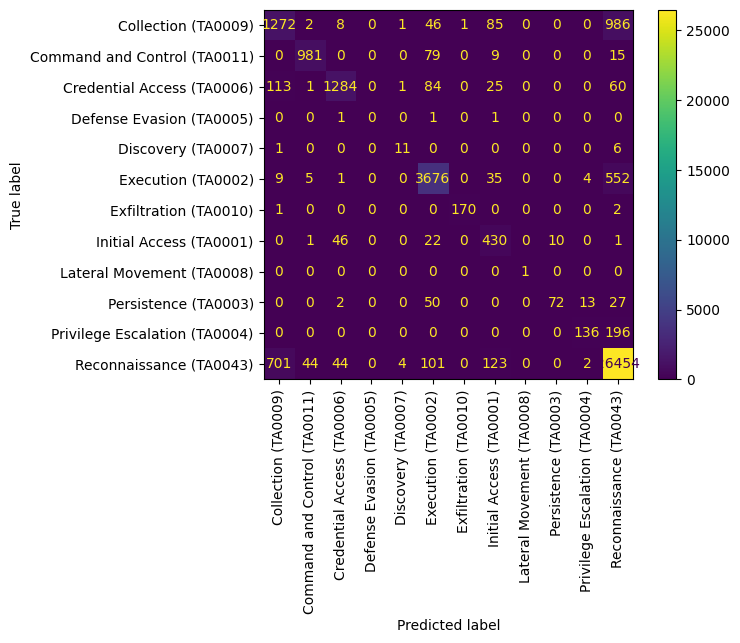

In [91]:
figure(figsize=(20, 10))
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=intersection)
cmd.plot(xticks_rotation='vertical')

## 2023/07

In [92]:
pred_list = []
ans_list = []


with torch.no_grad():
  for batch in tqdm(test_07_dataloader):

    batch = [i.to("cuda") for i in batch]
    sent_id, masks, labels = batch
    preds = model(sent_id, masks)
    outputs = preds.detach().cpu().numpy()
    pred_list.append(outputs)
    ans_list.append(labels.detach().cpu().numpy())

pred_list_final =[]

for i in range(len(pred_list)):
  for j in range(len(pred_list[i])):
    temp = np.argmax(pred_list[i][j])
    pred_list_final.append(temp)

a = pred_list_final
b = [e for sl in ans_list for e in sl]

y_true = np.array(b)
y_pred = np.array(a)

print()
print("Accuracy: %0.4f" % (accuracy_score(y_true, y_pred)))
print("Balance Accuracy: %0.4f" % (balanced_accuracy_score(y_true, y_pred)))
print("Precision macro: %0.4f" % (precision_score(y_true, y_pred, average='macro')))
print("Recall macro: %0.4f" % (recall_score(y_true, y_pred, average='macro')))
print("F1 macro: %0.4f" % (f1_score(y_true, y_pred, average='macro')))
print("Cohen's Kappa: %0.4f " % (cohen_kappa_score(y_true, y_pred)))

100%|██████████| 81/81 [02:14<00:00,  1.66s/it]


Accuracy: 0.9096
Balance Accuracy: 0.7162
Precision macro: 0.7879
Recall macro: 0.7162
F1 macro: 0.7327
Cohen's Kappa: 0.8355 



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
acc_07 = accuracy_score(y_true, y_pred)
bal_acc_07 = balanced_accuracy_score(y_true, y_pred)
f1_07 = f1_score(y_true, y_pred, average='macro')
kappa_07 = cohen_kappa_score(y_true, y_pred)

In [94]:
set_1 = frozenset(frozenset(encoder.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)))
set_2 = frozenset(list(df_07_class.Tactic_concate.unique()))
set_sum = set_1.union(set_2)
intersection = [x for x in list_1 if x in set_sum]
print(classification_report(y_true, y_pred, target_names=intersection, digits=4, zero_division=0))

                               precision    recall  f1-score   support

          Collection (TA0009)     0.7833    0.5272    0.6302      3105
 Command and Control (TA0011)     0.9207    0.9180    0.9194      1037
   Credential Access (TA0006)     0.9413    0.8301    0.8822      3673
     Defense Evasion (TA0005)     0.0000    0.0000    0.0000        49
           Discovery (TA0007)     0.7857    0.3143    0.4490        35
           Execution (TA0002)     0.9046    0.9390    0.9215      6231
        Exfiltration (TA0010)     0.9274    0.8984    0.9127       128
      Initial Access (TA0001)     0.4730    0.8958    0.6191       528
    Lateral Movement (TA0008)     1.0000    1.0000    1.0000         2
         Persistence (TA0003)     0.9875    0.7360    0.8434       322
Privilege Escalation (TA0004)     0.8000    0.5714    0.6667        35
      Reconnaissance (TA0043)     0.9318    0.9642    0.9478     26120

                     accuracy                         0.9096     41265
    

<Figure size 2000x1000 with 0 Axes>

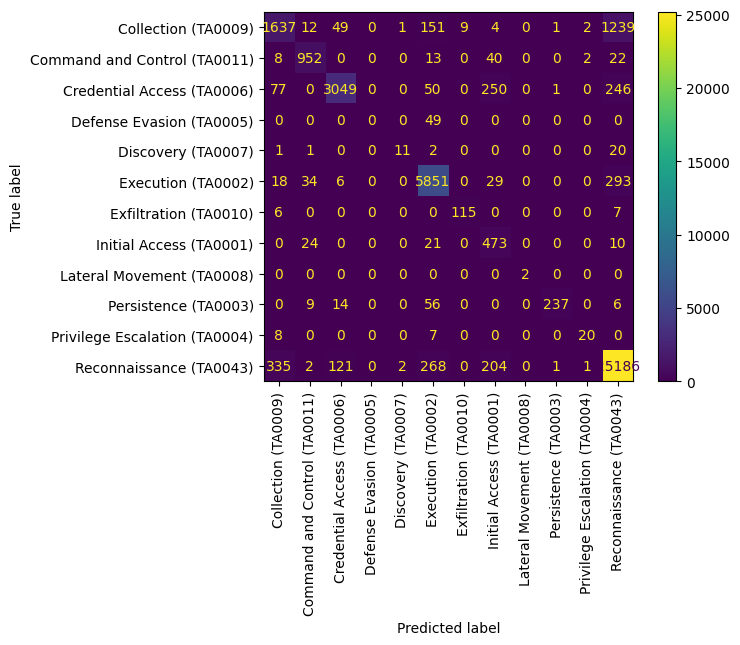

In [95]:
figure(figsize=(20, 10))
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=intersection)
cmd.plot(xticks_rotation='vertical')

## 2023/08

In [96]:
pred_list = []
ans_list = []


with torch.no_grad():
  for batch in tqdm(test_08_dataloader):

    batch = [i.to("cuda") for i in batch]
    sent_id, masks, labels = batch
    preds = model(sent_id, masks)
    outputs = preds.detach().cpu().numpy()
    pred_list.append(outputs)
    ans_list.append(labels.detach().cpu().numpy())

pred_list_final =[]

for i in range(len(pred_list)):
  for j in range(len(pred_list[i])):
    temp = np.argmax(pred_list[i][j])
    pred_list_final.append(temp)

a = pred_list_final
b = [e for sl in ans_list for e in sl]

y_true = np.array(b)
y_pred = np.array(a)

print()
print("Accuracy: %0.4f" % (accuracy_score(y_true, y_pred)))
print("Balance Accuracy: %0.4f" % (balanced_accuracy_score(y_true, y_pred)))
print("Precision macro: %0.4f" % (precision_score(y_true, y_pred, average='macro')))
print("Recall macro: %0.4f" % (recall_score(y_true, y_pred, average='macro')))
print("F1 macro: %0.4f" % (f1_score(y_true, y_pred, average='macro')))
print("Cohen's Kappa: %0.4f " % (cohen_kappa_score(y_true, y_pred)))

100%|██████████| 85/85 [02:21<00:00,  1.66s/it]


Accuracy: 0.8838
Balance Accuracy: 0.6990
Precision macro: 0.7318
Recall macro: 0.6990
F1 macro: 0.6938
Cohen's Kappa: 0.7870 



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [97]:
acc_08 = accuracy_score(y_true, y_pred)
bal_acc_08 = balanced_accuracy_score(y_true, y_pred)
f1_08 = f1_score(y_true, y_pred, average='macro')
kappa_08 = cohen_kappa_score(y_true, y_pred)

In [98]:
set_1 = frozenset(frozenset(encoder.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)))
set_2 = frozenset(list(df_08_class.Tactic_concate.unique()))
set_sum = set_1.union(set_2)
intersection = [x for x in list_1 if x in set_sum]
print(classification_report(y_true, y_pred, target_names=intersection, digits=4, zero_division=0))

                               precision    recall  f1-score   support

          Collection (TA0009)     0.7613    0.5723    0.6534      2497
 Command and Control (TA0011)     0.9438    0.9289    0.9363      1013
   Credential Access (TA0006)     0.7670    0.8667    0.8138      5115
     Defense Evasion (TA0005)     0.0000    0.0000    0.0000        12
           Discovery (TA0007)     0.6818    0.1648    0.2655        91
           Execution (TA0002)     0.9203    0.8716    0.8953      5380
        Exfiltration (TA0010)     0.8232    0.9739    0.8922       306
      Initial Access (TA0001)     0.5518    0.9317    0.6931       600
    Lateral Movement (TA0008)     1.0000    1.0000    1.0000         7
         Persistence (TA0003)     0.8033    0.7903    0.7967        62
Privilege Escalation (TA0004)     0.6076    0.3692    0.4593       130
      Reconnaissance (TA0043)     0.9210    0.9184    0.9197     28210

                     accuracy                         0.8838     43423
    

<Figure size 2000x1000 with 0 Axes>

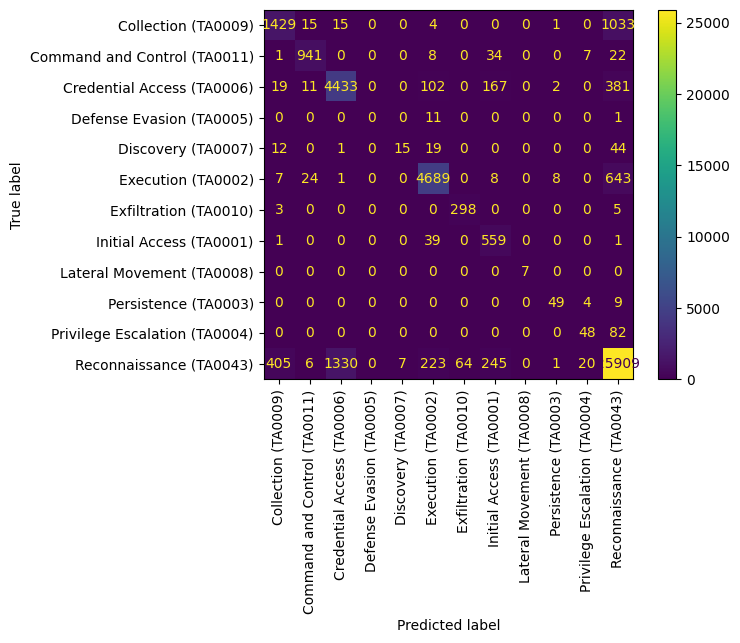

In [99]:
figure(figsize=(20, 10))
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=intersection)
cmd.plot(xticks_rotation='vertical')

## 2023/09

In [100]:
pred_list = []
ans_list = []


with torch.no_grad():
  for batch in tqdm(test_09_dataloader):

    batch = [i.to("cuda") for i in batch]
    sent_id, masks, labels = batch
    preds = model(sent_id, masks)
    outputs = preds.detach().cpu().numpy()
    pred_list.append(outputs)
    ans_list.append(labels.detach().cpu().numpy())

pred_list_final =[]

for i in range(len(pred_list)):
  for j in range(len(pred_list[i])):
    temp = np.argmax(pred_list[i][j])
    pred_list_final.append(temp)

a = pred_list_final
b = [e for sl in ans_list for e in sl]

y_true = np.array(b)
y_pred = np.array(a)

print()
print("Accuracy: %0.4f" % (accuracy_score(y_true, y_pred)))
print("Balance Accuracy: %0.4f" % (balanced_accuracy_score(y_true, y_pred)))
print("Precision macro: %0.4f" % (precision_score(y_true, y_pred, average='macro')))
print("Recall macro: %0.4f" % (recall_score(y_true, y_pred, average='macro')))
print("F1 macro: %0.4f" % (f1_score(y_true, y_pred, average='macro')))
print("Cohen's Kappa: %0.4f " % (cohen_kappa_score(y_true, y_pred)))

100%|██████████| 108/108 [02:59<00:00,  1.66s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Accuracy: 0.8027
Balance Accuracy: 0.5839
Precision macro: 0.6307
Recall macro: 0.5839
F1 macro: 0.5862
Cohen's Kappa: 0.6321 


In [101]:
acc_09 = accuracy_score(y_true, y_pred)
bal_acc_09 = balanced_accuracy_score(y_true, y_pred)
f1_09 = f1_score(y_true, y_pred, average='macro')
kappa_09 = cohen_kappa_score(y_true, y_pred)

In [102]:
set_1 = frozenset(frozenset(encoder.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)))
set_2 = frozenset(list(df_09_class.Tactic_concate.unique()))
set_sum = set_1.union(set_2)
intersection = [x for x in list_1 if x in set_sum]
print(classification_report(y_true, y_pred, target_names=intersection, digits=4, zero_division=0))

                               precision    recall  f1-score   support

          Collection (TA0009)     0.4865    0.4545    0.4699      1901
 Command and Control (TA0011)     0.9438    0.9286    0.9361      1176
   Credential Access (TA0006)     0.3435    0.8260    0.4852      3425
     Defense Evasion (TA0005)     0.0000    0.0000    0.0000        29
           Discovery (TA0007)     0.5000    0.1818    0.2667        99
           Execution (TA0002)     0.9373    0.7434    0.8292      9715
        Exfiltration (TA0010)     0.9459    0.8805    0.9121       159
      Initial Access (TA0001)     0.7358    0.9108    0.8140       942
    Lateral Movement (TA0008)     1.0000    0.5455    0.7059        11
         Persistence (TA0003)     0.5759    0.6233    0.5987       146
Privilege Escalation (TA0004)     0.8333    0.6667    0.7407        15
      Reconnaissance (TA0043)     0.8965    0.8298    0.8619     37403
Resource Development (TA0042)     0.0000    0.0000    0.0000         2

    

<Figure size 2000x1000 with 0 Axes>

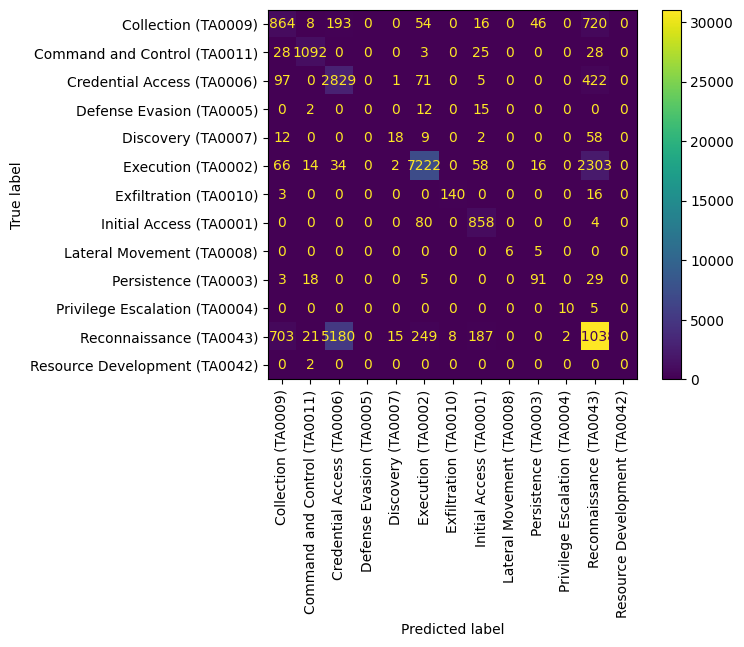

In [103]:
figure(figsize=(20, 10))
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=intersection)
cmd.plot(xticks_rotation='vertical')

## 2023/10

In [104]:
pred_list = []
ans_list = []


with torch.no_grad():
  for batch in tqdm(test_10_dataloader):

    batch = [i.to("cuda") for i in batch]
    sent_id, masks, labels = batch
    preds = model(sent_id, masks)
    outputs = preds.detach().cpu().numpy()
    pred_list.append(outputs)
    ans_list.append(labels.detach().cpu().numpy())

pred_list_final =[]

for i in range(len(pred_list)):
  for j in range(len(pred_list[i])):
    temp = np.argmax(pred_list[i][j])
    pred_list_final.append(temp)

a = pred_list_final
b = [e for sl in ans_list for e in sl]

y_true = np.array(b)
y_pred = np.array(a)

print()
print("Accuracy: %0.4f" % (accuracy_score(y_true, y_pred)))
print("Balance Accuracy: %0.4f" % (balanced_accuracy_score(y_true, y_pred)))
print("Precision macro: %0.4f" % (precision_score(y_true, y_pred, average='macro')))
print("Recall macro: %0.4f" % (recall_score(y_true, y_pred, average='macro')))
print("F1 macro: %0.4f" % (f1_score(y_true, y_pred, average='macro')))
print("Cohen's Kappa: %0.4f " % (cohen_kappa_score(y_true, y_pred)))

100%|██████████| 106/106 [02:55<00:00,  1.66s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Accuracy: 0.8170
Balance Accuracy: 0.6790
Precision macro: 0.6761
Recall macro: 0.6790
F1 macro: 0.6586
Cohen's Kappa: 0.6802 


In [105]:
acc_10 = accuracy_score(y_true, y_pred)
bal_acc_10 = balanced_accuracy_score(y_true, y_pred)
f1_10 = f1_score(y_true, y_pred, average='macro')
kappa_10 = cohen_kappa_score(y_true, y_pred)

In [106]:
set_1 = frozenset(frozenset(encoder.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)))
set_2 = frozenset(list(df_10_class.Tactic_concate.unique()))
set_sum = set_1.union(set_2)
intersection = [x for x in list_1 if x in set_sum]
print(classification_report(y_true, y_pred, target_names=intersection, digits=4, zero_division=0))

                               precision    recall  f1-score   support

          Collection (TA0009)     0.4483    0.6950    0.5450      1354
 Command and Control (TA0011)     0.9602    0.9342    0.9470      1110
   Credential Access (TA0006)     0.3051    0.6930    0.4237      3336
     Defense Evasion (TA0005)     0.0000    0.0000    0.0000        29
           Discovery (TA0007)     0.5500    0.2292    0.3235        48
           Execution (TA0002)     0.9461    0.8811    0.9124     11603
        Exfiltration (TA0010)     0.9851    0.9743    0.9797       272
      Initial Access (TA0001)     0.6096    0.8032    0.6931       554
    Lateral Movement (TA0008)     0.7500    0.8571    0.8000         7
         Persistence (TA0003)     0.8750    0.8018    0.8368       227
Privilege Escalation (TA0004)     0.7636    0.4667    0.5793       270
      Reconnaissance (TA0043)     0.9205    0.8119    0.8628     35209

                     accuracy                         0.8170     54019
    

<Figure size 2000x1000 with 0 Axes>

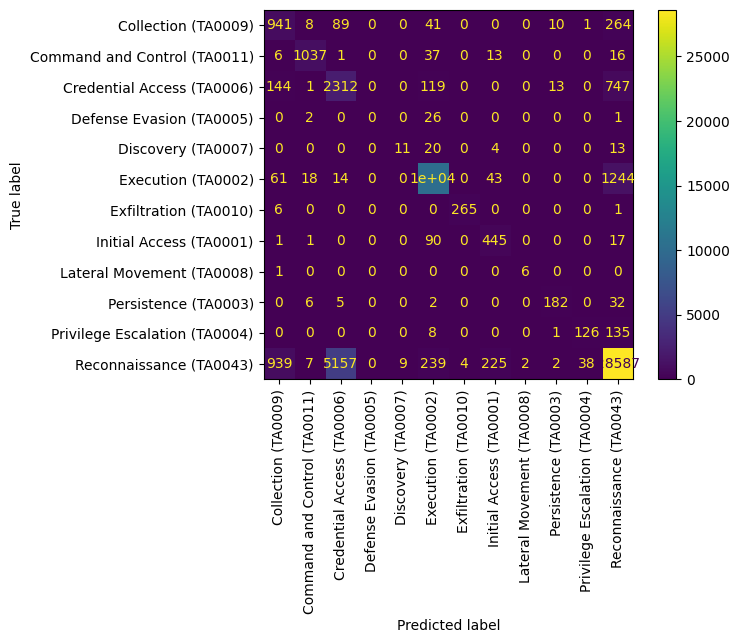

In [107]:
figure(figsize=(20, 10))
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=intersection)
cmd.plot(xticks_rotation='vertical')

## Combination chart

In [108]:
monthlist = [11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
m = [calendar.month_abbr[i] for i in monthlist]
print(m)

['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']


In [109]:
acc_result = [acc_11, acc_12, acc_01, acc_02, acc_03, acc_04, acc_05, acc_06, acc_07, acc_08, acc_09, acc_10]
bal_result = [bal_acc_11, bal_acc_12, bal_acc_01, bal_acc_02, bal_acc_03, bal_acc_04, bal_acc_05, bal_acc_06, bal_acc_07, bal_acc_08, bal_acc_09, bal_acc_10]
f1_result = [f1_11, f1_12, f1_01, f1_02, f1_03, f1_04, f1_05, f1_06, f1_07, f1_08, f1_09, f1_10]
kappa_result = [kappa_11, kappa_12, kappa_01, kappa_02, kappa_03, kappa_04, kappa_05, kappa_06, kappa_07, kappa_08, kappa_09, kappa_10]

In [110]:
print(acc_result)
print(bal_result)
print(f1_result)
print(kappa_result)

[0.9649621750753654, 0.8629847689747856, 0.9213654567414659, 0.9317203276814632, 0.9275052054312444, 0.8520451693851945, 0.8861538461538462, 0.9073377357994159, 0.9095601599418394, 0.883794302558552, 0.8027188630209185, 0.8170273422314371]
[0.9478669292047281, 0.7359901228989663, 0.7929607001510374, 0.7892940159425015, 0.7248136483941645, 0.5700785832697916, 0.6068310947158225, 0.6967162512073496, 0.7162187592751068, 0.6989819422879274, 0.5839096691049341, 0.6789581732644893]
[0.9409519115084772, 0.7420072399907003, 0.792167927470267, 0.7998750513180731, 0.7629743797066467, 0.6281477721545389, 0.5714771752248499, 0.7215203048042018, 0.7326607769183958, 0.6937836062418867, 0.5861826399443296, 0.6586178109757228]
[0.9533431221236033, 0.8019411003149723, 0.8891481639855815, 0.8620320715683049, 0.7873265597499952, 0.6068294172465789, 0.7513348974363138, 0.7911776286286227, 0.8355427562453492, 0.7869803976837991, 0.6321245527460624, 0.6801519668002067]


### Accuracy

<ipython-input-111-1654b12d94bb>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b:" (-> color='b'). The keyword argument will take precedence.
  plt.plot(m, acc_result, 'b:', marker='o', color = "orchid")


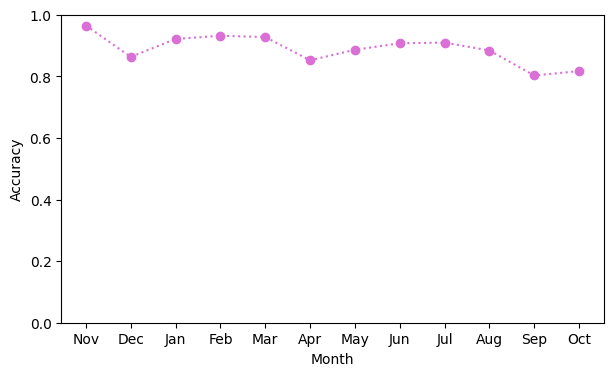

In [111]:
plt.figure(figsize=(7,4))

plt.plot(m, acc_result, 'b:', marker='o', color = "orchid")
plt.xlabel("Month")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

### Balanced Accuracy

<ipython-input-112-ab1db44de217>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b:" (-> color='b'). The keyword argument will take precedence.
  plt.plot(m, bal_result, 'b:', marker='o', color = "orchid")


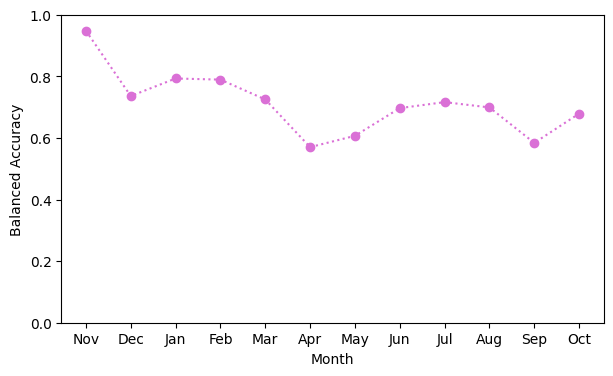

In [112]:
plt.figure(figsize=(7,4))

plt.plot(m, bal_result, 'b:', marker='o', color = "orchid")
plt.xlabel("Month")
plt.ylabel("Balanced Accuracy")
plt.ylim(0, 1)
plt.show()

### F1 Macro

<ipython-input-113-957829a15cb8>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b:" (-> color='b'). The keyword argument will take precedence.
  plt.plot(m, f1_result, 'b:', marker='o', color = "orchid")


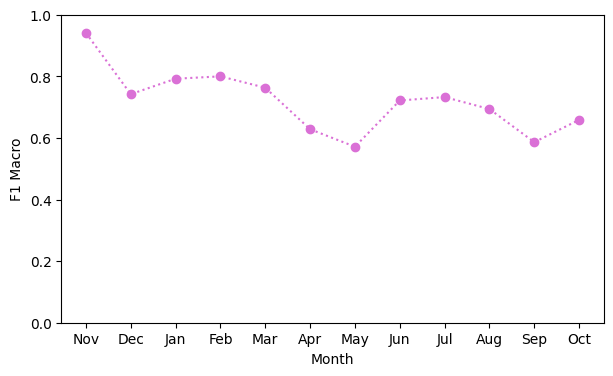

In [113]:
plt.figure(figsize=(7,4))

plt.plot(m, f1_result, 'b:', marker='o', color = "orchid")
plt.xlabel("Month")
plt.ylabel("F1 Macro")
plt.ylim(0, 1)
plt.show()

### Cohen's Kappa

<ipython-input-114-b31aaff2219d>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b:" (-> color='b'). The keyword argument will take precedence.
  plt.plot(m, kappa_result, 'b:', marker='o', color = "orchid")


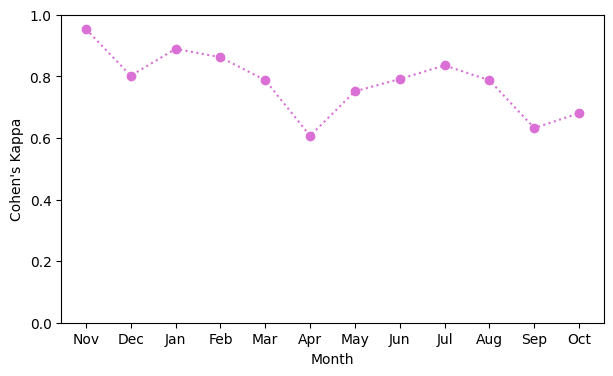

In [114]:
plt.figure(figsize=(7,4))
plt.plot(m, kappa_result, 'b:', marker='o', color = "orchid")
plt.xlabel("Month")
plt.ylabel("Cohen's Kappa")
plt.ylim(0, 1)
plt.show()